In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime


from sklearn import set_config
set_config(transform_output = "pandas")

# Frame the Problem and Look at the Big Picture

1. Define the objective in business terms.
- Enhance risk management by implementing a predictive model that accurately determines the likelihood of a loan applicant defaulting. This model aims to reduce financial losses by enabling proactive decision-making on loan applications.

2. How will your solution be used?
- The predictive model will be integrated into the existing loan approval system to augment decision-making. When an application is received, the system will use the model to approve, reject, or suggest modified loan terms to their discretion. This assists loan officers by providing a data-driven risk assessment, which complements their expertise.

3. What are the current solutions/workarounds (if any)?
- Current solutions include manual assessment based on credit scores and financial ratios. These methods rely heavily on loan officers' subjective judgment and might not consistently capture all risk factors, especially those subtle patterns identifiable only through data analysis

4. How should you frame this problem (supervised/unsupervised, online/offline, ...)?
-This problem is best framed as a supervised binary classification task where each application is labeled as 'default' or 'no default.' 

5. How should performance be measured? Is the performance measure aligned with the business objective?
- The key performance metrics will be precision and recall, particularly focusing on minimizing false negatives (approving high-risk applications). The business objective is to reduce defaults, so prioritizing recall (sensitivity) might be essential to capture as many potential defaults as possible, even at the expense of some false positives.

6. What would be the minimum performance needed to reach the business objective?
- The model should achieve at least a 10% improvement in identifying potential defaults over current methods, which would substantively decrease financial losses due to defaults.

7. What are comparable problems? Can you reuse experience or tools?
- This problem shares similarities with credit card fraud detection where anomaly detection and classification methods are used. We can use experience that other people on the internet have with these types of problems.

8. Is human expertise available?
- No

9. How would you solve the problem manually?
- Manually, loan officers review applications based on credit reports, repayment history, and financial statements, making decisions based on guidelines that might not dynamically adjust to changing economic conditions or new patterns of default.

10. List the assumptions you (or others) have made so far. Verify assumptions if possible.
- We assume that the historical data on defaults is indicative of future trends and that the selected features sufficiently capture the risk factors associated with defaults. These assumptions will be validated through continuous performance monitoring and feedback from loan officers on the ground.

# Get the Data

1. List the data you need and how much you need
- Anonymised Loan Default data for predicting if a loan will default or not

2. Find and document where you can get that data
- https://www.kaggle.com/datasets/joebeachcapital/loan-default/data

3. Get access authorizations

4. Create a workspace (with enough storage space)

5. Get the data

6. Convert the data to a format you can easily manipulate (without changing the data itself)

7. Ensure sensitive information is deleted or protected (e.g. anonymized)

8. Check the size and type of data (time series, geographical, ...). 

    Size of Data
    - 38,480 rows x 37 columns

    Type of Data
    - float64(19), int64(4), object(14)

    Is it a time series?
    - No

    Are any of the features unusable for the business problem?
    - id , zipcode , Unamed: 0 

    Which feature(s) will be used as the target/label for the business problem? (including which are required to derive the correct label)
    - repay_fail

    Should any of the features be stratified during the train/test split to avoid sampling biases?
    - Based on the distribution, we should stratify to maintain the target variable's distribution.

    Stratify repay_fail

9. Sample a test set, put it aside, and never look at it (no data snooping!)

In [148]:
def drop_unwanted_columns(dataframe):
    """
    Drops 'id', 'zipcode', and 'Unnamed: 0' columns from the DataFrame if they exist.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame from which to drop the columns.

    Returns:
    pd.DataFrame: A DataFrame with the specified columns removed.
    """
    # List of columns to drop
    columns_to_drop = ['id', 'zipcode', 'Unnamed: 0']
    
    # Drop columns only if they exist in the DataFrame to avoid KeyError
    for column in columns_to_drop:
        if column in dataframe.columns:
            dataframe = dataframe.drop(column, axis=1)
    
    return dataframe

def split_data(data, target_column_name):
    """
    Splits the data into training and test sets while stratifying based on the target variable.

    Parameters:
    data (pd.DataFrame): The DataFrame to split.
    target_column_name (str): The name of the target column to stratify by.

    Returns:
    pd.DataFrame: The training set as a DataFrame.
    pd.DataFrame: The test set as a DataFrame.
    """
    # Ensure the target column exists in the DataFrame
    if target_column_name not in data.columns:
        raise ValueError(f"The target column {target_column_name} does not exist in the DataFrame.")

    # Split the data into training and test sets with stratification
    train_set, test_set = train_test_split(
        data, 
        test_size=0.2, 
        random_state=42, 
        stratify=data[target_column_name]  # Stratify based on the target column
    )
    
    return train_set, test_set

In [149]:
# Load the dataset
file_path = 'Anonymize_Loan_Default_data.csv'  # Replace with your actual file path
Loan_Data = pd.read_csv(file_path, encoding='ISO-8859-1')

Loan_Data_Cleaned = drop_unwanted_columns(Loan_Data)
train_data, test_data = split_data(Loan_Data_Cleaned, 'repay_fail')

In [31]:
# Check the result to confirm that columns have been dropped
Loan_Data_Cleaned.head() 

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
0,2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,RENT,0.0,...,1.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,Jan-07,1
1,703644,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,RENT,20004.0,...,10.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,Aug-13,Jun-16,0
2,687836,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,RENT,59000.0,...,15.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,NaN,Mar-12,1
3,1092507,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,MORTGAGE,53796.0,...,20.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,NaN,Mar-14,0
4,1089981,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,RENT,30000.0,...,15.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,NaN,Jun-16,0


In [32]:
Loan_Data_Cleaned.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'repay_fail'],
      dtype='object')

In [33]:
Loan_Data_Cleaned.size

1346800

In [34]:
Loan_Data_Cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38480 entries, 0 to 38479
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   member_id               38480 non-null  int64  
 1   loan_amnt               38479 non-null  float64
 2   funded_amnt             38479 non-null  float64
 3   funded_amnt_inv         38479 non-null  float64
 4   term                    38480 non-null  object 
 5   int_rate                38480 non-null  float64
 6   installment             38479 non-null  float64
 7   emp_length              37487 non-null  object 
 8   home_ownership          38480 non-null  object 
 9   annual_inc              38478 non-null  float64
 10  verification_status     38480 non-null  object 
 11  issue_d                 38480 non-null  object 
 12  loan_status             38480 non-null  object 
 13  purpose                 38480 non-null  object 
 14  zip_code                38480 non-null

In [35]:
Loan_Data_Cleaned.head

<bound method NDFrame.head of        member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0              2        0.0          0.0          0.00000  36 months   
1         703644     2500.0       2500.0       2500.00000  36 months   
2         687836     5000.0       5000.0       5000.00000  36 months   
3        1092507     7000.0       7000.0       7000.00000  36 months   
4        1089981     2000.0       2000.0       2000.00000  36 months   
...          ...        ...          ...              ...        ...   
38475    1060907     3000.0       3000.0       3000.00000  36 months   
38476    1065048    10400.0      10400.0      10400.00000  36 months   
38477     671637    16000.0      10550.0      10531.35818  60 months   
38478    1034448    10000.0      10000.0      10000.00000  36 months   
38479    1249126     3200.0       3200.0       3200.00000  36 months   

       int_rate  installment emp_length home_ownership  annual_inc  ...  \
0          0.00         0.00  

In [36]:
Loan_Data_Cleaned.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail
count,3.848000e+04,38479.000000,38479.000000,38479.000000,38480.00000,38479.000000,3.847800e+04,38480.000000,38479.000000,38479.000000,...,38479.000000,38479.000000,3.847600e+04,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38480.000000
mean,8.261899e+05,11094.727644,10831.856337,10150.141518,12.16430,323.163255,6.899531e+04,13.378119,0.151927,1.083942,...,9.342966,0.057902,1.428987e+04,22.108501,11980.696892,11274.519569,9646.412705,2232.768235,2614.441757,0.151481
std,2.793531e+05,7405.416042,7146.853682,7128.026828,3.73744,209.089097,6.447639e+04,6.744356,0.507592,1.534814,...,4.498075,0.245707,2.194138e+04,11.588602,9006.505205,8946.229941,7051.828302,2570.177312,4391.969583,0.358522
min,1.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.384620e+05,5200.000000,5100.000000,4950.000000,9.62000,165.740000,4.000000e+04,8.200000,0.000000,0.000000,...,6.000000,0.000000,3.639750e+03,13.000000,5463.099238,4811.735000,4400.000000,657.700000,212.010000,0.000000
50%,8.242545e+05,9750.000000,9600.000000,8495.792749,11.99000,277.980000,5.865000e+04,13.485000,0.000000,1.000000,...,9.000000,0.000000,8.839500e+03,20.000000,9673.221341,8953.240000,8000.000000,1335.090000,526.000000,0.000000
75%,1.034706e+06,15000.000000,15000.000000,14000.000000,14.72000,429.350000,8.200000e+04,18.690000,0.000000,2.000000,...,12.000000,0.000000,1.726550e+04,29.000000,16402.394995,15486.925000,13315.100000,2795.020000,3169.815000,0.000000
max,1.314167e+06,35000.000000,35000.000000,35000.000000,100.99000,1305.190000,6.000000e+06,100.000000,11.000000,33.000000,...,47.000000,5.000000,1.207359e+06,90.000000,58563.679930,58563.680000,35000.020000,23611.100000,36115.200000,1.000000


In [37]:
Loan_Data_Cleaned.isnull().sum()

member_id                     0
loan_amnt                     1
funded_amnt                   1
funded_amnt_inv               1
term                          0
int_rate                      0
installment                   1
emp_length                  993
home_ownership                0
annual_inc                    2
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   1
earliest_cr_line              0
inq_last_6mths                1
mths_since_last_delinq    24363
open_acc                      1
pub_rec                       1
revol_bal                     4
revol_util                   59
total_acc                     1
total_pymnt                   1
total_pymnt_inv               1
total_rec_prncp               1
total_rec_int                 1
last_pymnt_d                 71
last_pym

In [14]:
Loan_Data_Cleaned.duplicated().sum()

np.int64(0)

In [38]:
Loan_Data_Cleaned['home_ownership'].value_counts()

home_ownership
RENT        18253
MORTGAGE    17140
OWN          2958
OTHER         125
NONE            4
Name: count, dtype: int64

In [39]:
target_column = 'repay_fail' 
Loan_Data_Cleaned[target_column].value_counts(normalize=True)

repay_fail
0    0.848519
1    0.151481
Name: proportion, dtype: float64

Explore the Data
================


1. Copy the data for exploration, downsampling to a manageable size if necessary.

2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...)

3. For supervised learning tasks, identify the target attribute(s)

4. Visualize the data

5. Study the correlations between attributes

## Correlation Analysis with `repay_fail`

## Strong Negative Correlations
- **`total_rec_prncp` (-0.343569)**: The total principal received from borrowers negatively correlates with repayment failure. This suggests that as more of the principal is paid off, the likelihood of repayment failure decreases.
- **`total_pymnt` (-0.247553) and `total_pymnt_inv` (-0.245060)**: Similar to `total_rec_prncp`, these indicate that higher total payments are associated with a lower risk of repayment failure. This implies successful repayments are linked with fewer failures.

## Moderate Positive Correlation
- **`int_rate` (0.199220)**: A higher interest rate correlates moderately with a higher chance of repayment failure, which could reflect higher financial strain on borrowers leading to defaults.

## Mild to Low Correlations
- **`funded_amnt` (0.039306)**, **`loan_amnt` (0.042252)**, and **`dti` (0.042096)**: These show slight positive correlations with repayment failure, suggesting that larger loan amounts and higher debt-to-income ratios might marginally increase the risk of default.
- **`last_pymnt_amnt` (-0.220334)**: Indicates that lower last payment amounts are associated with a higher chance of repayment failure, potentially signaling issues with borrower liquidity towards the end of the loan term.

    
6. Study how you would solve the problem manually

 - First we have to understand the problem, and how our actions will effect our client 
 
 - Collect data which we already have but if were doing this manually we can find more data

 - Manually review the borrower’s credit history for any past delinquencies, defaults, and overall credit behavior. (Also, look at how much the borrowers income is)

 - Manually compute financial ratios like the loan-to-income ratio, which can give quick insights into the affordability of the loan for the borrower.

 - Compare the current loan application with historical data of loans that have failed in the past.

 - Based on our analysis, decide whether to approve, reject, or modify the terms of the loan. Modification could include adjusting the loan amount, extending the term, or changing the interest rate.

7. Identify the promising transformations you may want to apply

- We could log transform to reduce skewness loan_amnt, annual_inc, total_pymnt. 

- We could OHE home_ownership and loan_status. 

- Create new features by considering interactions between different features. For example, the interaction between loan_amnt and annual_inc might provide useful signals about the financial burden of the loan relative to the borrower's income.

- Create new features by considering interactions between different features. For example, the interaction between loan_amnt and annual_inc might provide useful signals about the financial burden of the loan relative to the borrower's income.

- 


8. Identify extra data that would be useful (go back to “Get the Data”)



| Name                   | Type            | Noise | Distribution                                                                   | Missing Values  |
|------------------------|-----------------|-------|--------------------------------------------------------------------------------|-----------------|
| id                     | Numerical       | maybe | muti-modal                                                                     | no              |
| member_id              | Numerical       | no    | multi-modal                                                                    | no              |
| loan_amnt              | Numerical       | no    | multi-modal                                                                    | no              |
| funded_amnt            | Numerical       | no    | multimodal                                                                     | no              |
| funded_amnt_inv        | Float/Numerical | no    | multimodal                                                                     | no              |
| term                   | Numerical       | no    | 36 months 74%  60 months 26%                                                   | no              |
| int_rate               | float           | no    | Unimodal                                                                       | no              |
| installment            | float           | no    | right skewed                                                                   | no              |
| emp_length             | object          | no    | 10+ years 22%  < 1 year 12%  Other (25450) 66%                                 | no              |
| home_ownership         | String          | no    | RENT 47%  MORTGAGE 45%  Other (3087) 8%                                        | no              |
| annual_inc             | float           |       | right skewed                                                                   | no              |
| verification_status    | String          | no    | Not Verified 44%  Verified 32%  Other (9348) 24%                               | no              |
| issue_d                | Object          | no    | Nov-11 5%  Dec-11 5%  Other (34356) 89%                                        | no              |
| loan_status            | String          | no    | Fully Paid 78%  Charged Off 13%  Other (3382) 9%                               | no              |
| purpose                | String          | no    | debt_consolidation 47%  credit_card 13%  Other (15589) 41%                     | no              |
| zip_code               | object          | no    | 100xx 1%  945xx 1%  Other (37405) 97%                                          | no              |
| addr_state             | String          | no    | CA 18%  NY 10%  Other (28024) 73%                                              | no              |
| # dti                  | float           | no    | normal                                                                         | no              |
| delinq_2yrs            | Numerical       | no    | skewed towards 0                                                               | no              |
| earliest_cr_line       | object          | maybe | 528 Unique values                                                              | no              |
| inq_last_6mths         | Numerical       | no    | highly skewed towards 0                                                        | no              |
| mths_since_last_delinq | Numerical       | no    | uniform decline from 0 up to around 20 months,  and then gradually tapers off. | yes             |
| open_acc               | Numerical       | no    | multimodal distribution                                                        | yes             |
| pub_rec                | Numerical       | no    | 0 94%  1 5%  Other (72) 0%                                                     | no              |
| revol_bal              | Numerical       | no    | distribution sharply decreasing after a certain point                          | no              |
| revol_util             | Float object    | no    | 0% 2%  0.10% 0%  Other (37471) 97%                                             | no              |
| total_acc              | Numerical       | no    | right skewed                                                                   | no              |
| total_pymnt            | float           | no    | right skewed                                                                   | no              |
| total_pymnt_inv        | float           | no    | right skewed                                                                   | no              |
| total_rec_prncp        | Numerical/float | no    | multimodal                                                                     | no              |
| total_rec_int          | Float           | no    | right skewed                                                                   | no              |
| last_pymnt_d           | Object          | no    | distribution gradually declines                                                | no              |
| last_pymnt_amnt        | float           | no    | right skewed                                                                   | no              |
| next_pymnt_d           | object          | no    | NA 91%  Jul-16 2%  Other (2474) 6%                                             | yes             |
| last_credit_pull_d     | object          |       | Jun-16 29%  Mar-16 3%  Other (26123) 68%                                       | no              |
| repay_fail             | Numerical       | no    |                                                                                | no              |

- potentially dropping colums: id, member_id 

- Normalize Loan Data by State: When analyzing addr_state, adjust for the number of loans or normalize data based on state population to prevent bias.

- Model Sensitivity to DTI: Given the importance of dti in loan performance, ensure your models can differentiate well across the spectrum of DTI values, particularly paying attention to higher DTIs.

- Imbalance Techniques for Delinquencies: Apply appropriate methods to manage the skewed distribution of delinq_2yrs to enhance model accuracy and predictiveness, especially if delinquency prediction is a goal.





In [40]:
Loan_Data_explore = Loan_Data_Cleaned.copy()

In [54]:
Loan_Data_explore['addr_state'].value_counts(normalize=False).sort_values(ascending=False)

addr_state
CA    6754
NY    3702
FL    2803
TX    2633
NJ    1795
IL    1523
PA    1491
GA    1371
VA    1343
MA    1285
OH    1209
MD    1010
AZ     856
WA     798
CO     771
NC     747
CT     722
MI     708
MO     677
MN     597
NV     485
WI     473
AL     439
SC     438
OR     419
LA     415
KY     313
OK     284
KS     271
UT     254
AR     238
DC     196
NM     186
RI     186
NH     170
HI     168
WV     166
DE     124
MT      88
WY      78
AK      77
SD      57
VT      52
TN      30
MS      24
IN      19
IA      12
NE      10
ID       8
ME       3
AA       1
ZZ       1
Name: count, dtype: int64

In [41]:
Loan_Data_explore.value_counts()

member_id  loan_amnt  funded_amnt  funded_amnt_inv  term       int_rate  installment  emp_length  home_ownership  annual_inc  verification_status  issue_d  loan_status                                          purpose             zip_code  addr_state  dti    delinq_2yrs  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  open_acc  pub_rec  revol_bal  revol_util  total_acc  total_pymnt   total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_d  last_pymnt_amnt  next_pymnt_d  last_credit_pull_d  repay_fail
80039      2000.0     2000.0       1275.000000      36 months  7.12      61.87        7 years     MORTGAGE        150000.0    Not Verified         Jul-07   Does not meet the credit policy. Status:Fully Paid   debt_consolidation  068xx     CT          5.60   0.0          Mar-84            0.0             0.0                     7.0       0.0      150786.0   2.20%       16.0       2227.023184   1419.73          2000.00          227.02         Jul-10        63.59            Jul

In [42]:
Loan_Data_explore['member_id'].value_counts()

member_id
2          1
130794     1
1253838    1
933746     1
623916     1
          ..
1228886    1
459091     1
500726     1
409569     1
1249126    1
Name: count, Length: 38480, dtype: int64

# Distributions

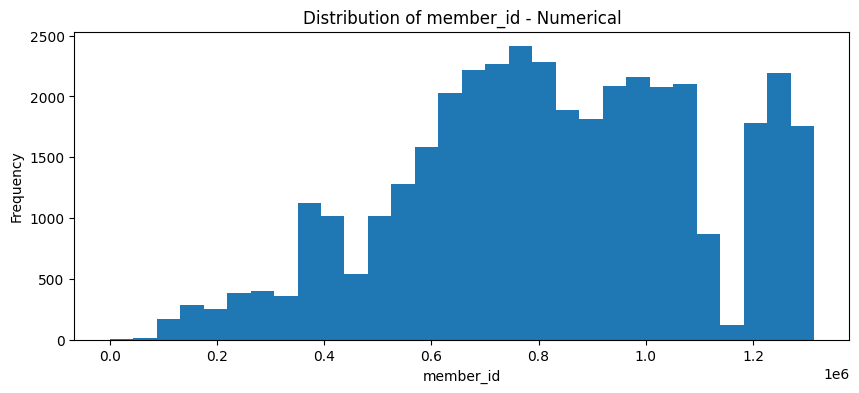

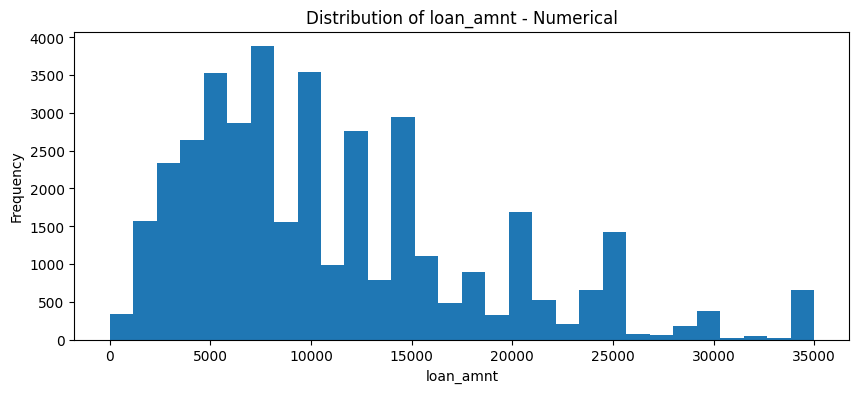

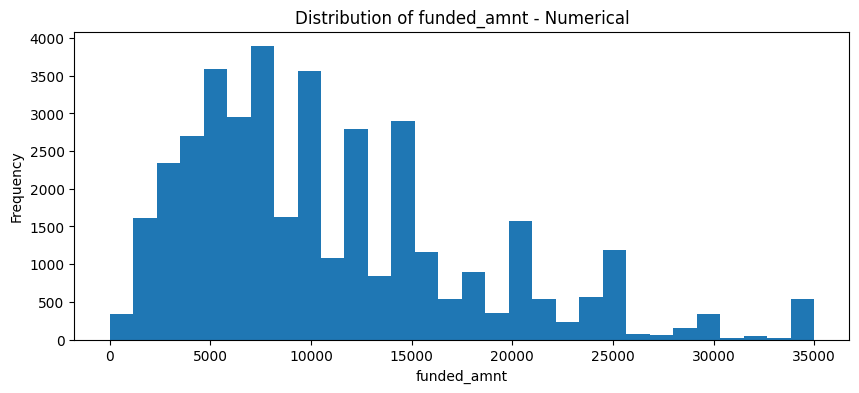

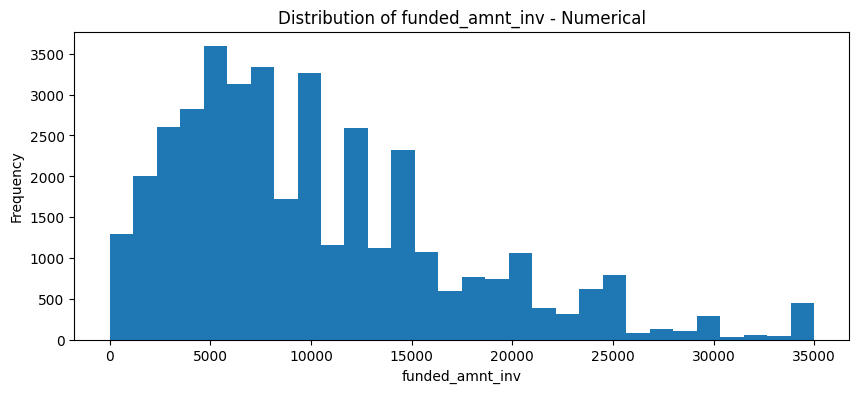

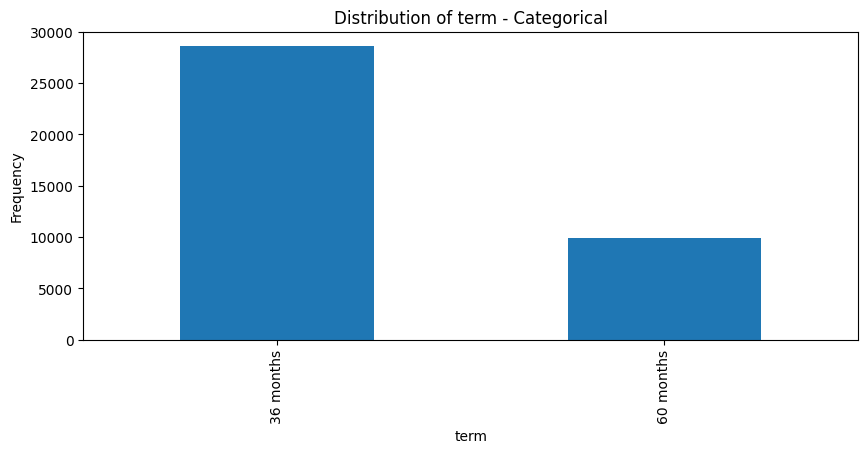

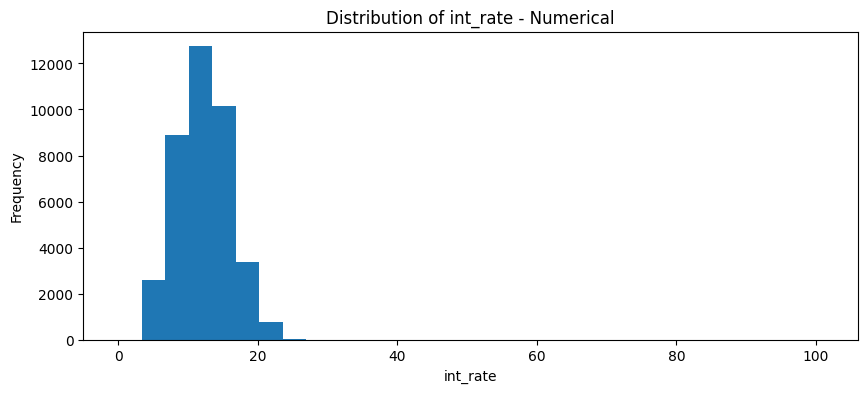

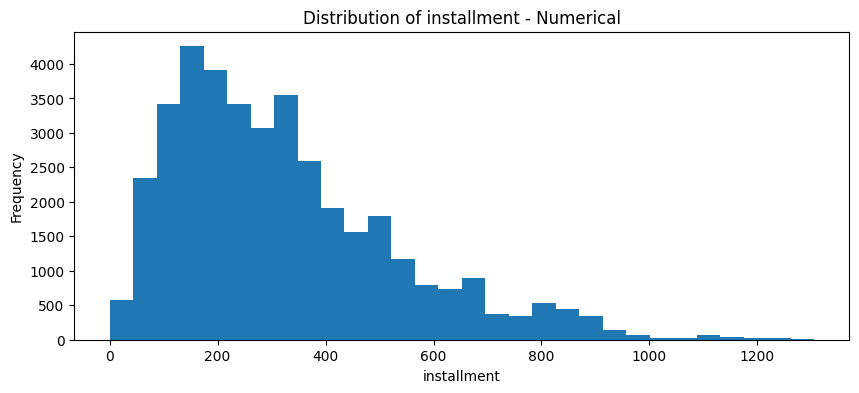

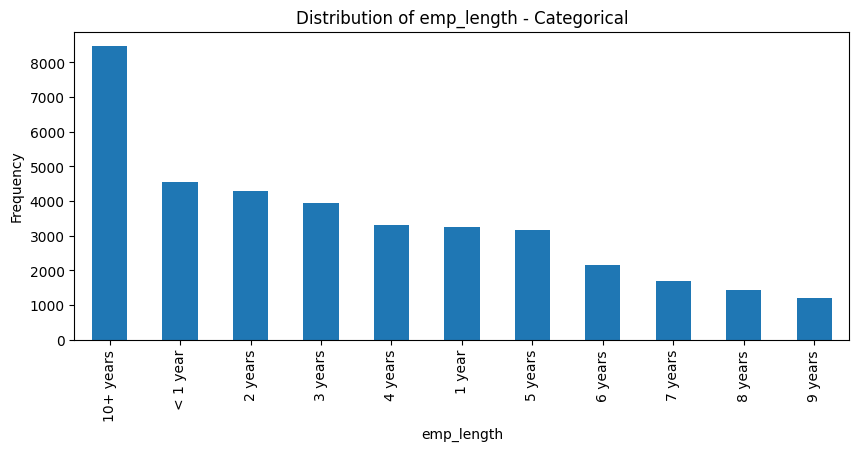

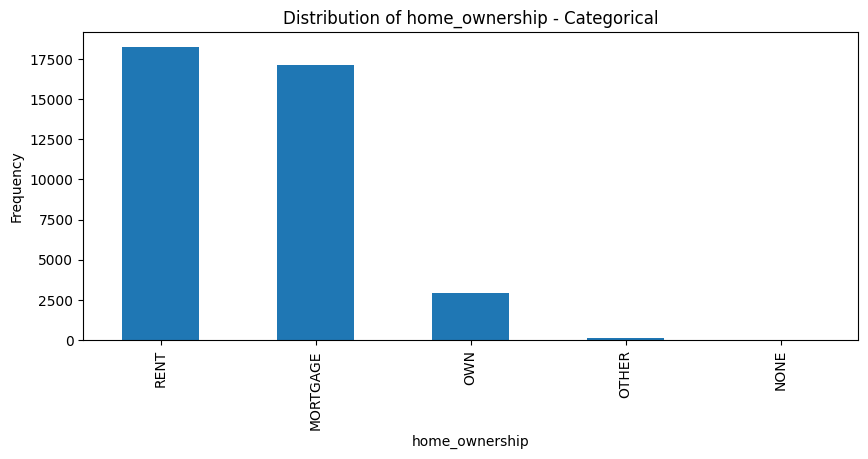

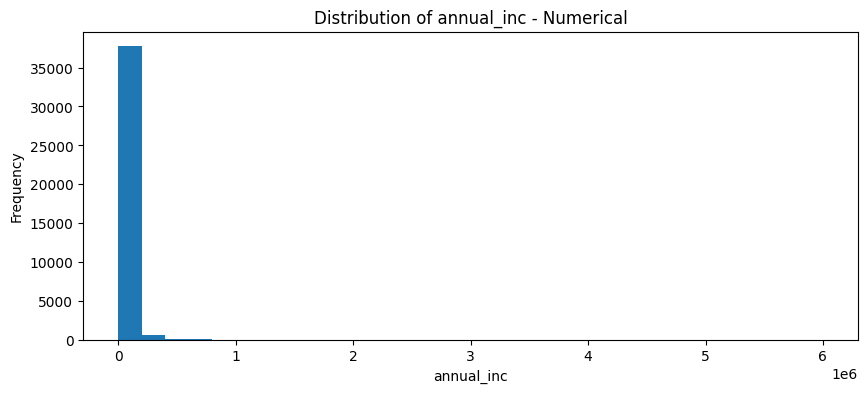

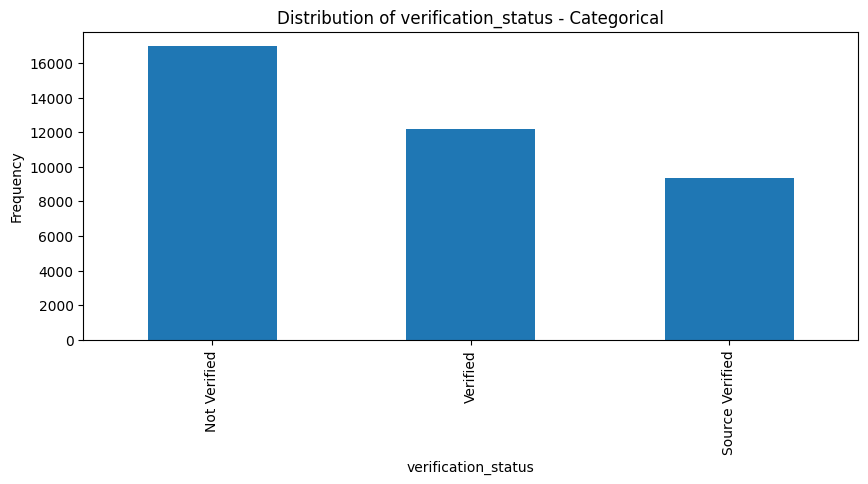

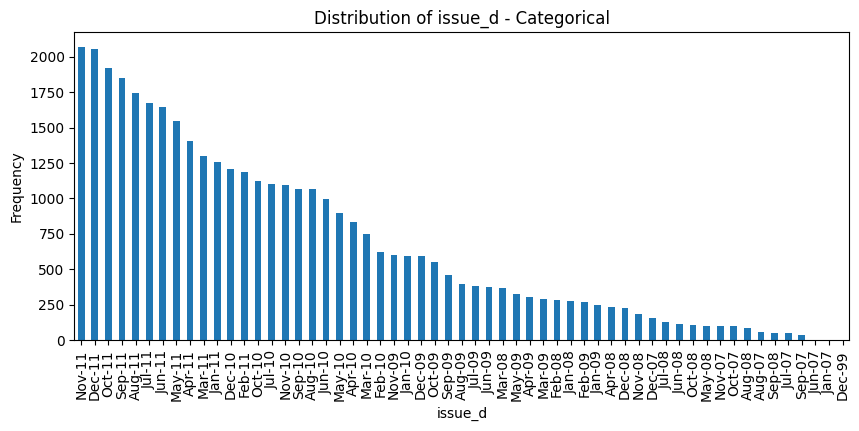

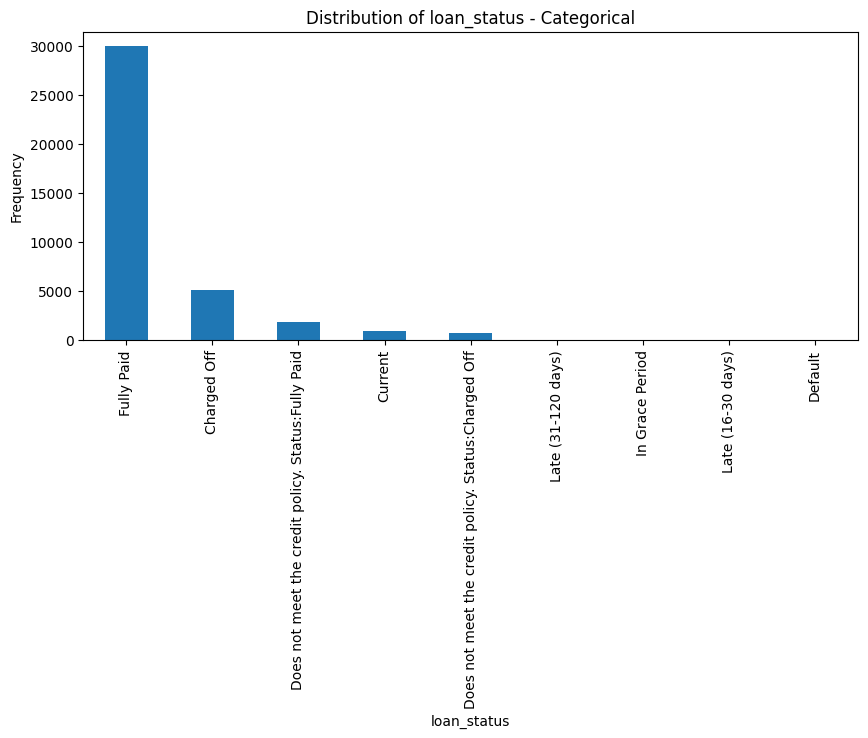

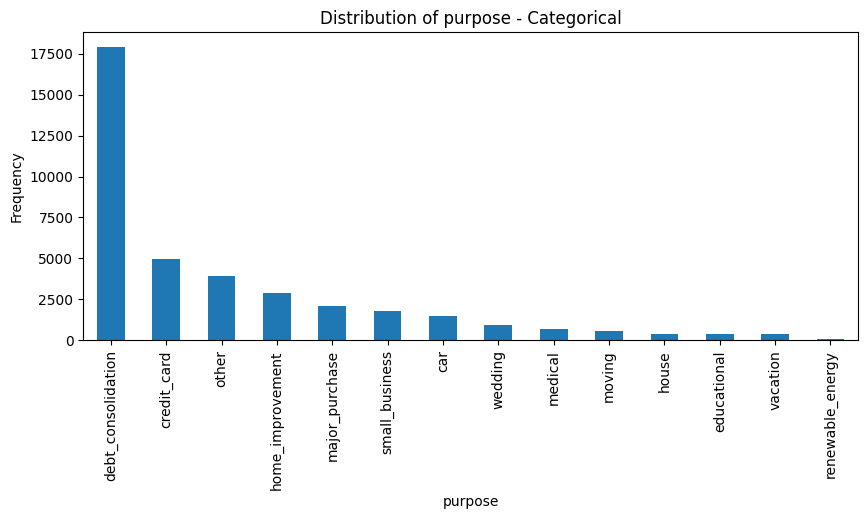

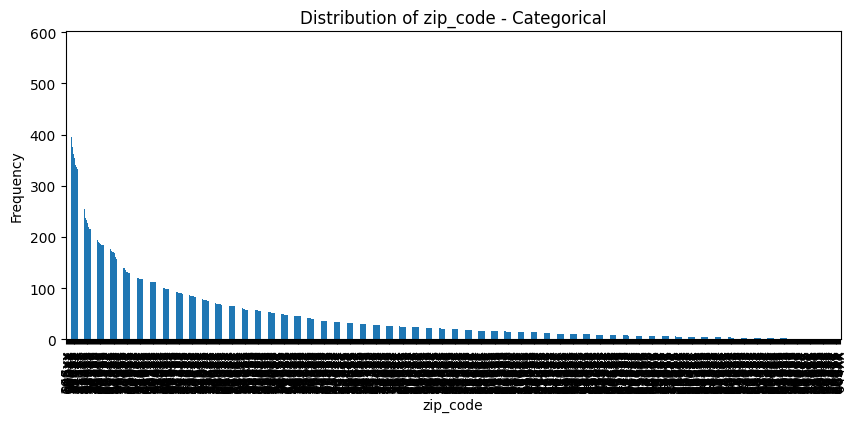

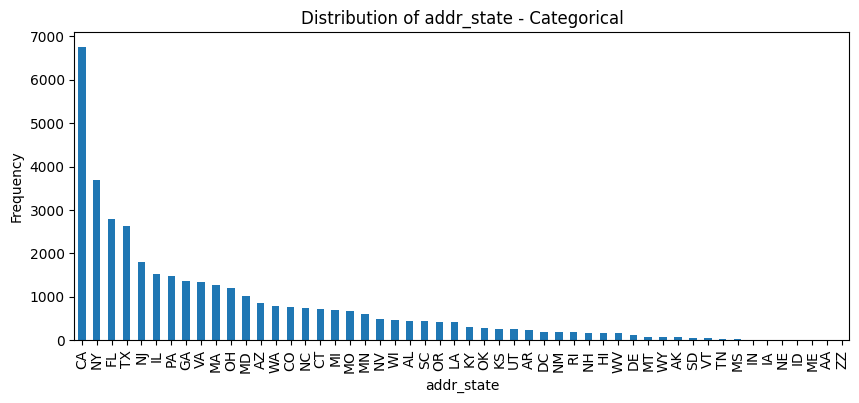

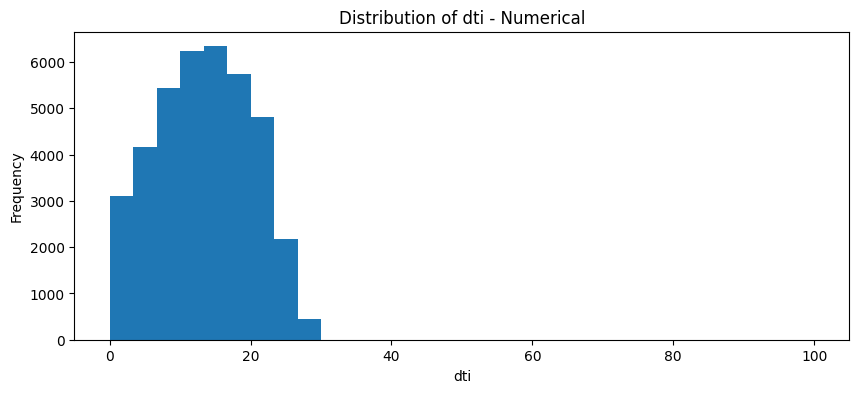

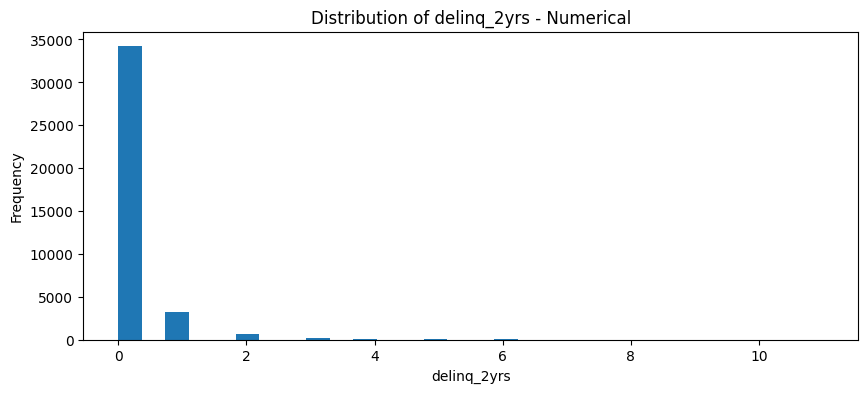

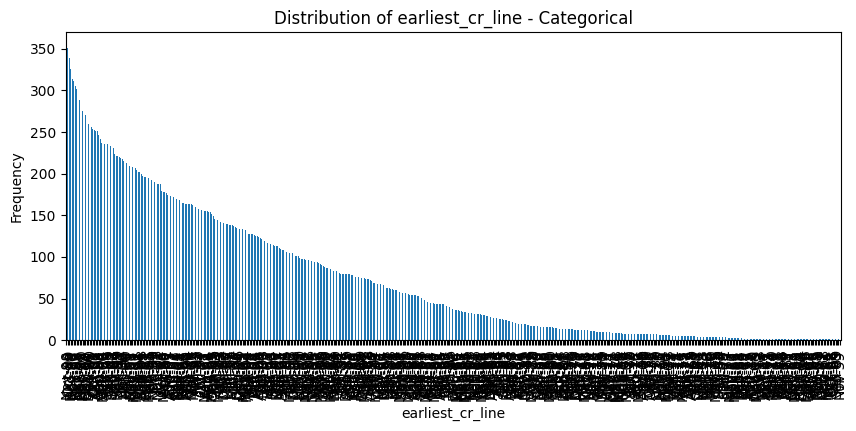

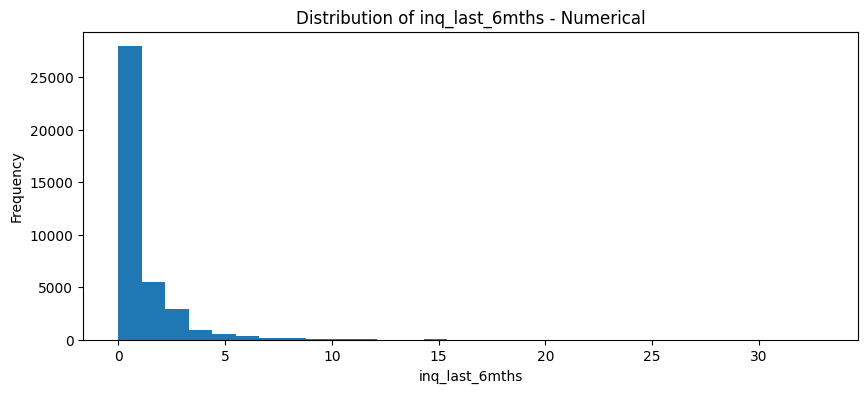

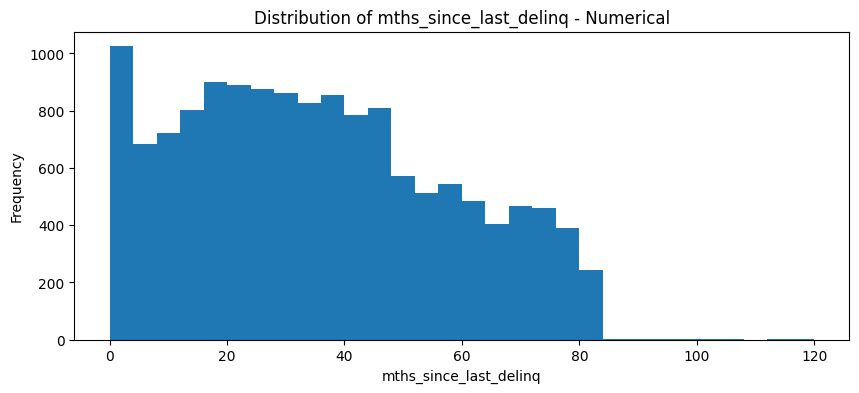

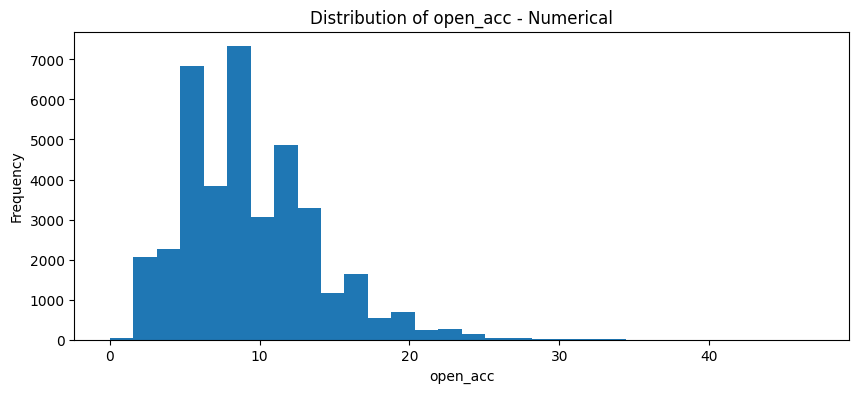

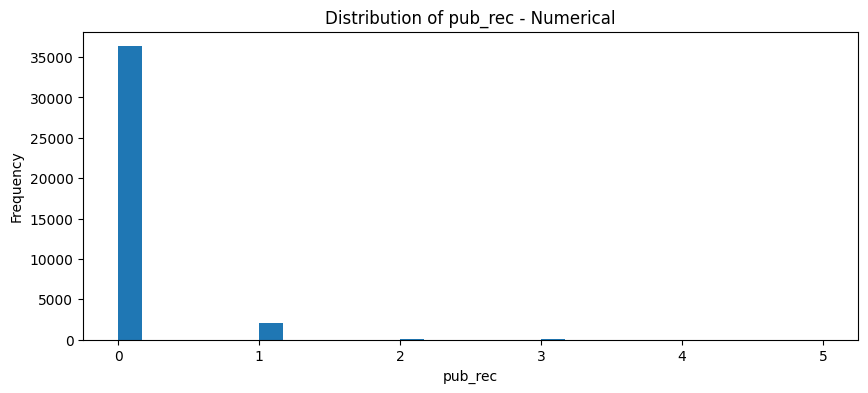

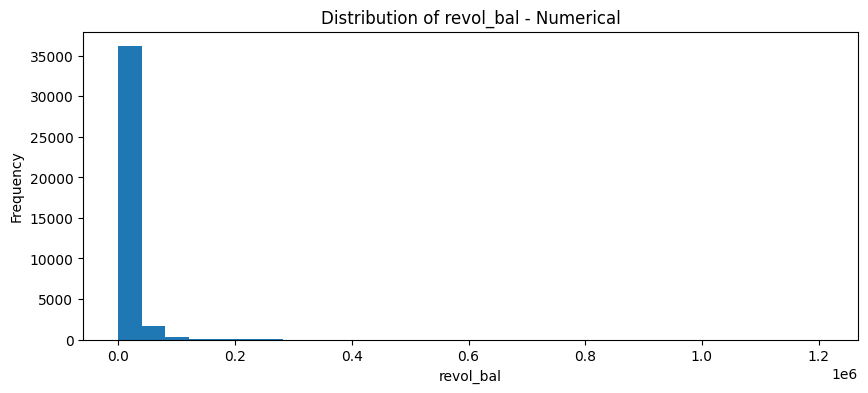

/Users/jyounes/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jyounes/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


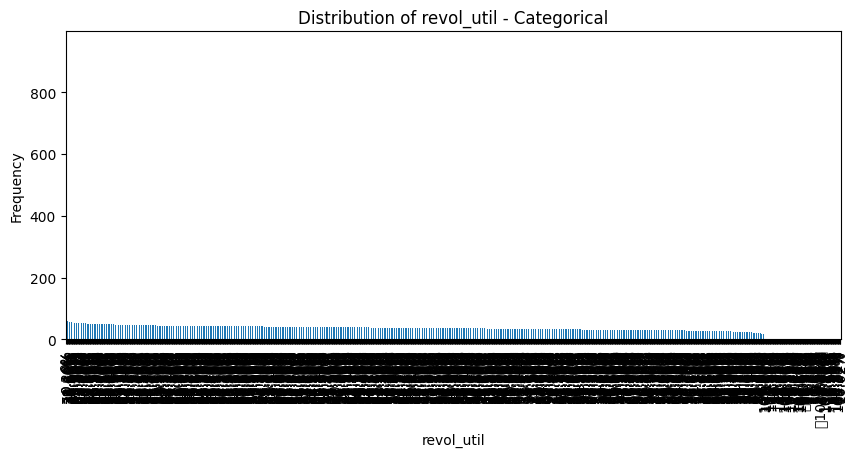

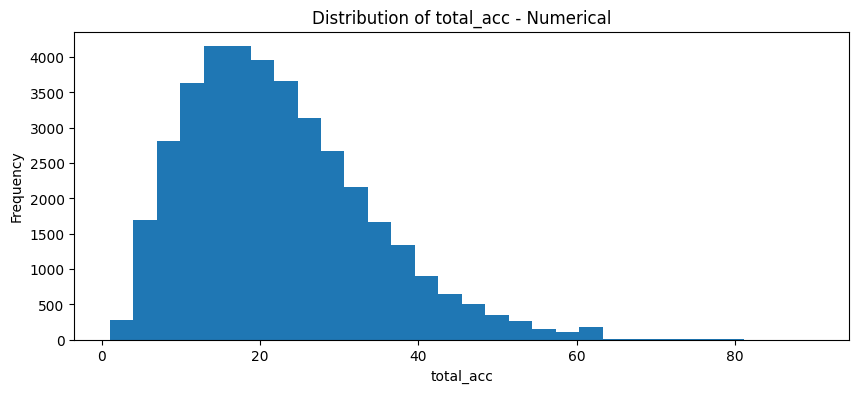

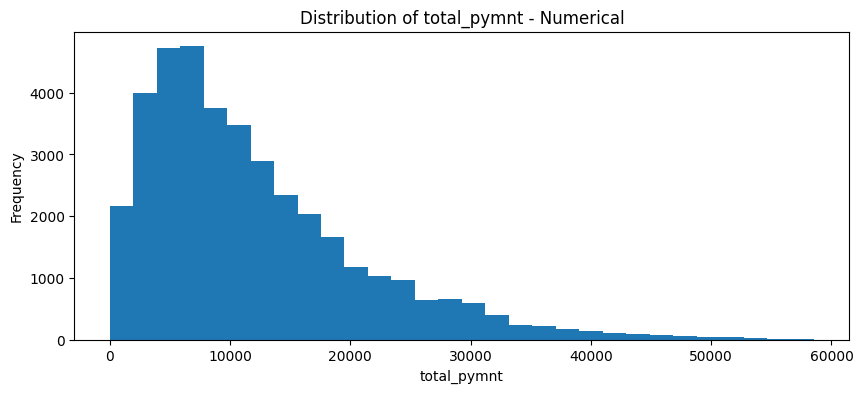

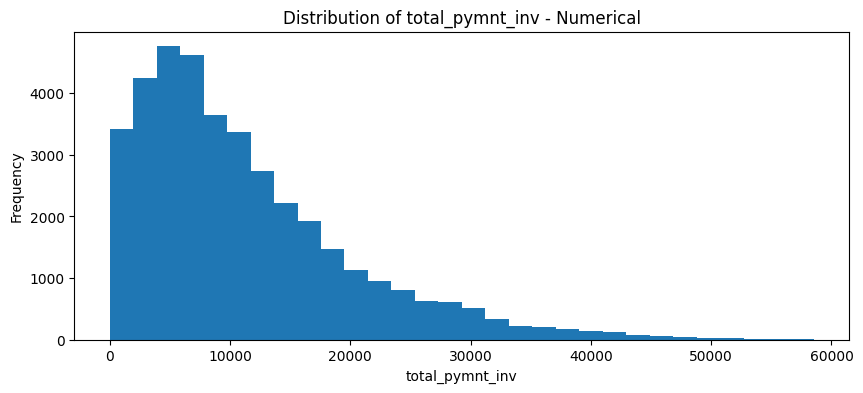

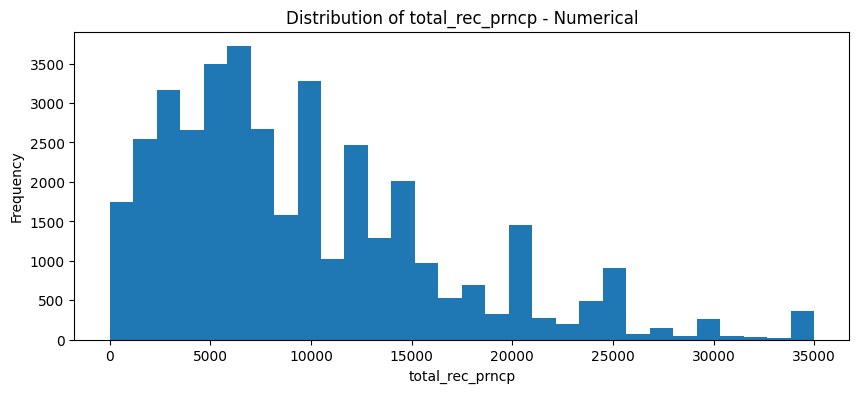

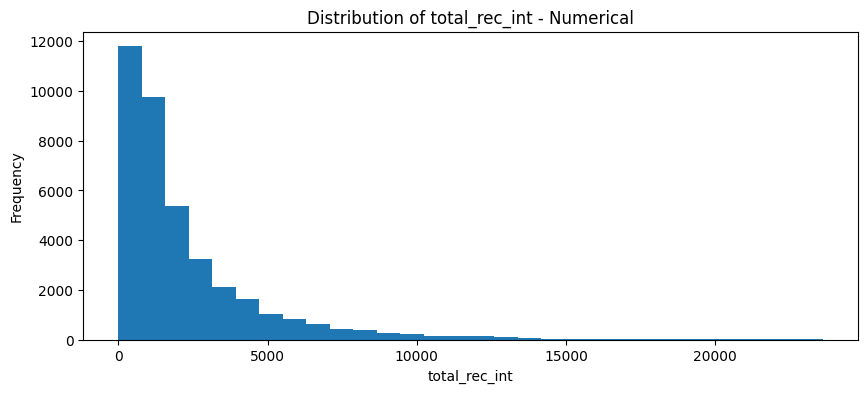

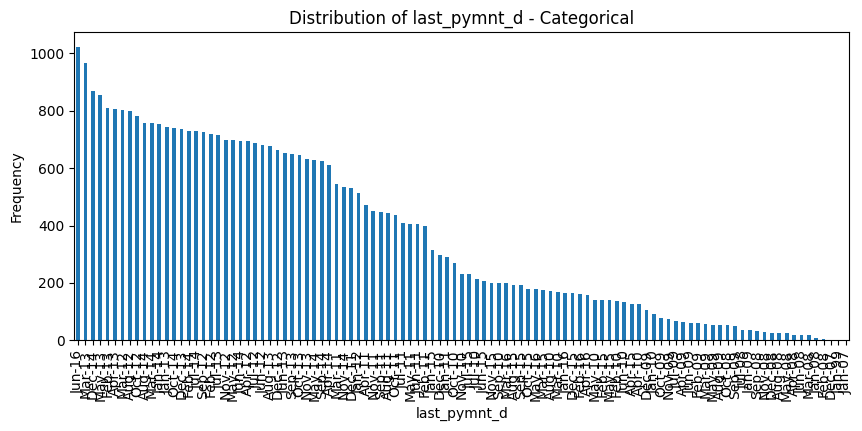

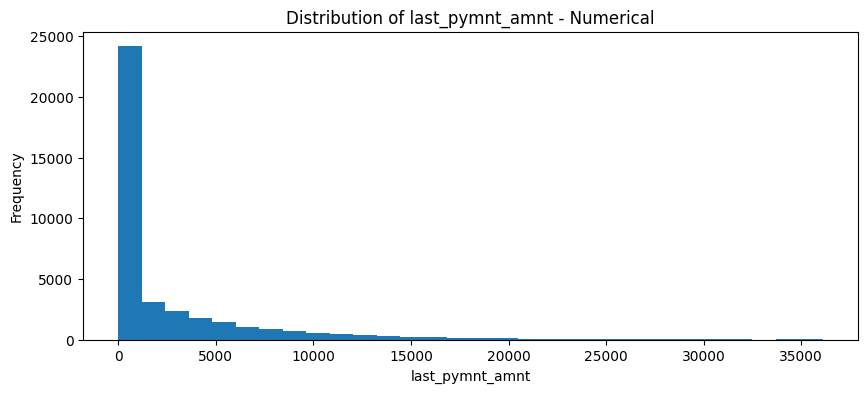

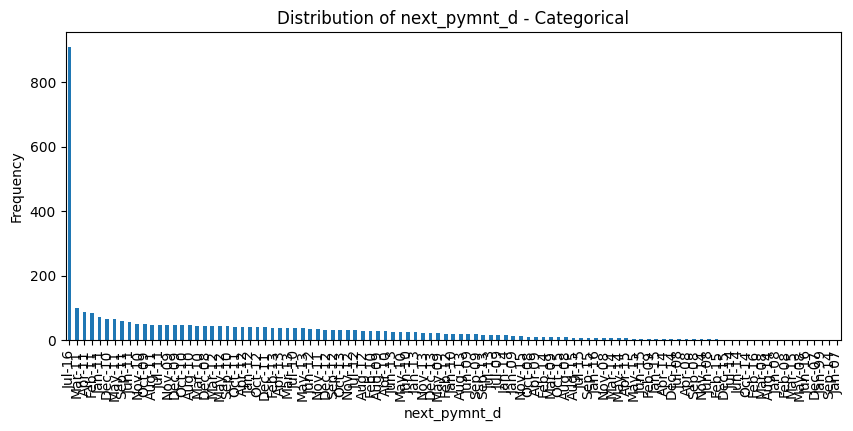

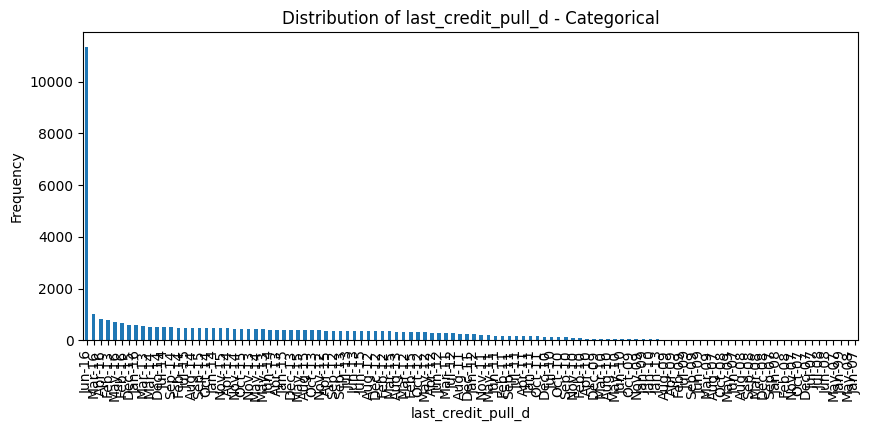

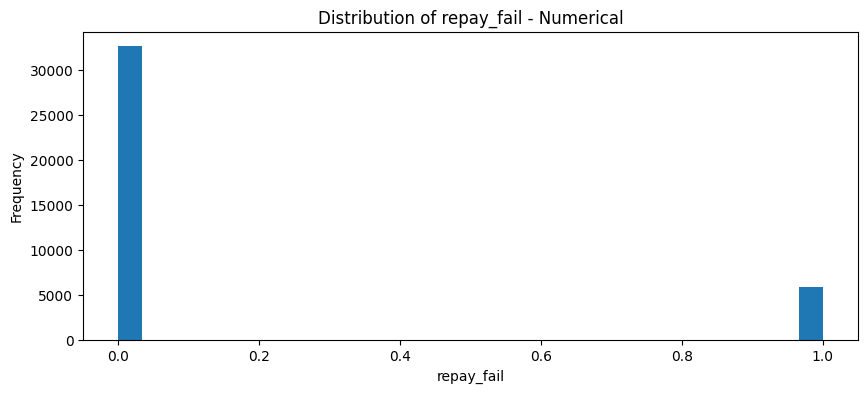

In [55]:
# Function to plot the distribution of each column
def plot_distributions(dataframe):
    for column in dataframe.columns:
        plt.figure(figsize=(10, 4))
        # Check data type of the column
        if dataframe[column].dtype == 'object':  # Categorical data
            # Use value_counts to see the distribution of categorical data
            value_count = dataframe[column].value_counts()
            value_count.plot(kind='bar')
            plt.title(f'Distribution of {column} - Categorical')
        else:  # Numerical data
            # Use histogram to see the distribution of numerical data
            dataframe[column].hist(bins=30)
            plt.title(f'Distribution of {column} - Numerical')
        plt.ylabel('Frequency')
        plt.xlabel(column)
        plt.grid(False)
        plt.show()

# Call the function with your dataframe
plot_distributions(Loan_Data_explore)

total_rec_prncp          -0.343569
total_pymnt              -0.247553
total_pymnt_inv          -0.245060
last_pymnt_amnt          -0.220334
annual_inc               -0.037959
total_acc                -0.020695
mths_since_last_delinq   -0.017414
total_rec_int            -0.017394
open_acc                 -0.006320
revol_bal                 0.018898
delinq_2yrs               0.020481
installment               0.020604
funded_amnt               0.039306
dti                       0.042096
loan_amnt                 0.042252
int_rate                  0.199220
repay_fail                1.000000
Name: repay_fail, dtype: float64


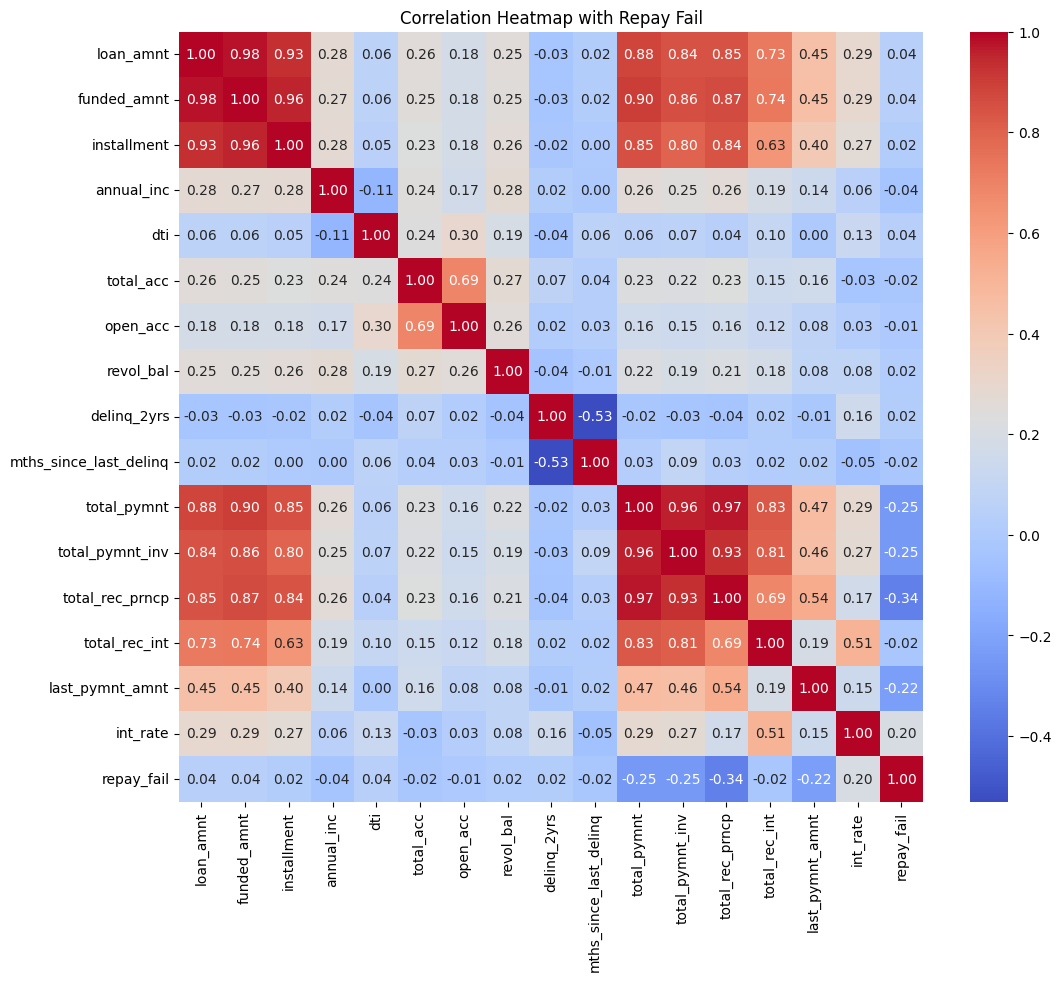

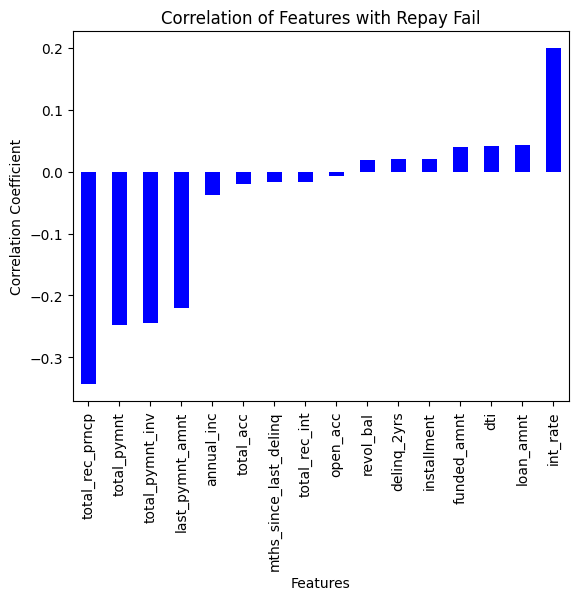

In [56]:
#check correlation of features with repay_fail column 

# List of potential features to check against 'repay_fail'
features = [
    'loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti',
    'total_acc', 'open_acc', 'revol_bal', 'delinq_2yrs',
    'mths_since_last_delinq', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
    'total_rec_int', 'last_pymnt_amnt','int_rate'
]

# Calculate correlation matrix for the features plus 'repay_fail'
correlation_matrix = Loan_Data_explore[features + ['repay_fail']].corr()

# Print correlation of features with 'repay_fail'
repay_fail_correlations = correlation_matrix['repay_fail'].sort_values()
print(repay_fail_correlations)


# Calculate correlation matrix for the features plus 'repay_fail'
correlation_matrix = Loan_Data_explore[features + ['repay_fail']].corr()

# Focusing on the 'repay_fail' row/column in the correlation matrix
repay_fail_correlations = correlation_matrix['repay_fail'].sort_values()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap with Repay Fail')
plt.show()

# Bar plot for correlations with 'repay_fail'
repay_fail_correlations.drop('repay_fail').plot(kind='bar', color='blue')
plt.title('Correlation of Features with Repay Fail')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

Correlation between int_rate > 20.00 and repay_fail: 0.08223219072071816


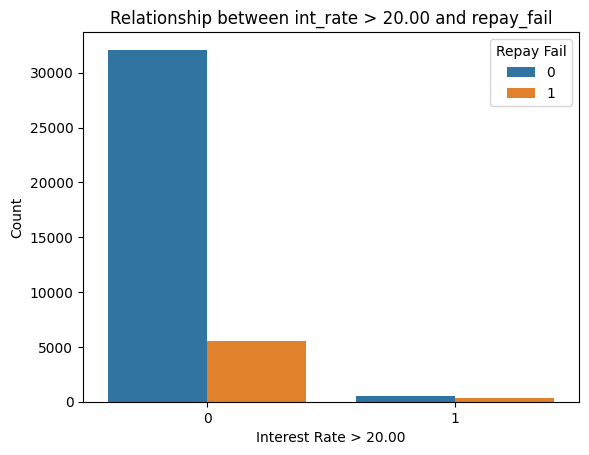

In [57]:
# Create a binary column for interest rates over 20.00
Loan_Data_explore['int_rate_over_20'] = (Loan_Data_explore['int_rate'] > 20.00).astype(int)

# Calculate the correlation with repay_fail
correlation = Loan_Data_explore[['int_rate_over_20', 'repay_fail']].corr().iloc[0, 1]
print(f"Correlation between int_rate > 20.00 and repay_fail: {correlation}")

# Visualize the relationship
sns.countplot(data=Loan_Data_explore, x="int_rate_over_20", hue="repay_fail")
plt.title("Relationship between int_rate > 20.00 and repay_fail")
plt.xlabel("Interest Rate > 20.00")
plt.ylabel("Count")
plt.legend(title="Repay Fail", loc="upper right")
plt.show()

### Implications
- **Risk Management**: Lenders should focus on loans with higher interest rates and potentially set more stringent approval criteria or monitoring processes for these loans.
- **Financial Advice**: Borrowers might benefit from guidance on managing loans with higher principal amounts or unfavorable terms to avoid repayment failures.
- **Loan Structuring**: Adjusting terms or offering more tailored repayment plans for borrowers with higher DTIs or those borrowing near their limit may help reduce default rates.

Correlation between int_rate > 12.00 and repay_fail: 0.16000928057093994


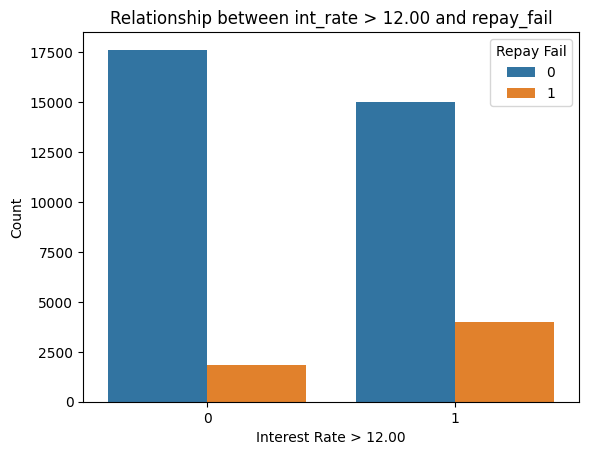

In [75]:
# Create a binary column for interest rates over 20.00
Loan_Data_explore['int_rate_over_12'] = (Loan_Data_explore['int_rate'] > 12.00).astype(int)

# Calculate the correlation with repay_fail
correlation = Loan_Data_explore[['int_rate_over_12', 'repay_fail']].corr().iloc[0, 1]
print(f"Correlation between int_rate > 12.00 and repay_fail: {correlation}")

# Visualize the relationship
sns.countplot(data=Loan_Data_explore, x="int_rate_over_12", hue="repay_fail")
plt.title("Relationship between int_rate > 12.00 and repay_fail")
plt.xlabel("Interest Rate > 12.00")
plt.ylabel("Count")
plt.legend(title="Repay Fail", loc="upper right")
plt.show()

In [63]:
# Convert 'issue_d' to datetime assuming the year is represented with two digits
Loan_Data['issue_d'] = pd.to_datetime(Loan_Data['issue_d'], format='%b-%y')

# Extract the month from 'issue_d' and create a new column
Loan_Data['issue_month'] = Loan_Data['issue_d'].dt.month

In [64]:
# Calculate mean 'repay_fail' for each 'issue_month'
monthly_repay_fail = Loan_Data.groupby('issue_month')['repay_fail'].mean()

# Sort the results to see which months have the highest failure rates
sorted_monthly_repay_fail = monthly_repay_fail.sort_values(ascending=False)
print(sorted_monthly_repay_fail)

issue_month
5     0.161672
12    0.160104
10    0.159306
6     0.159040
1     0.157629
11    0.154492
9     0.152762
4     0.144248
7     0.144185
8     0.141922
3     0.140798
2     0.132372
Name: repay_fail, dtype: float64


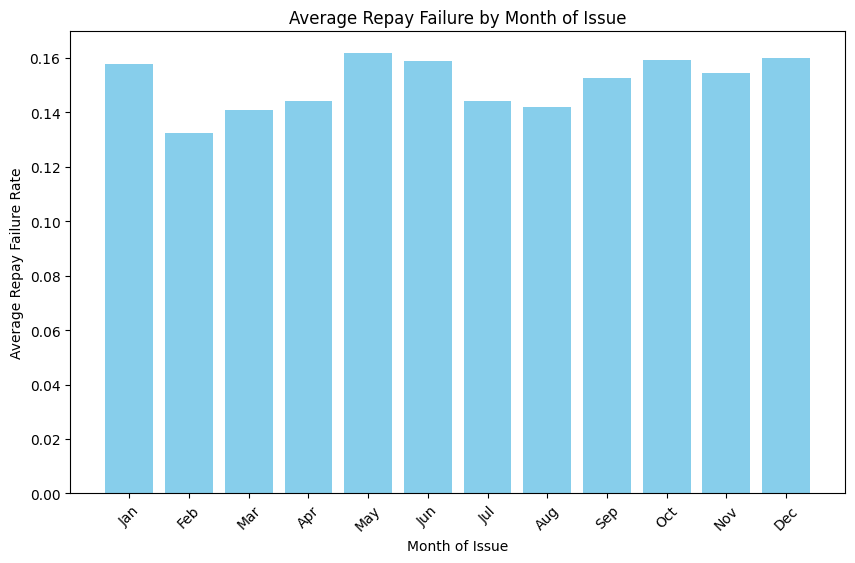

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'Loan_Data' is already loaded and 'issue_d' converted to datetime
Loan_Data['issue_month'] = Loan_Data['issue_d'].dt.month

# Calculate mean 'repay_fail' for each 'issue_month' and sort by month for chronological plotting
monthly_repay_fail = Loan_Data.groupby('issue_month')['repay_fail'].mean().sort_index()

# Create a bar plot in chronological order
plt.figure(figsize=(10, 6))
plt.bar(monthly_repay_fail.index, monthly_repay_fail, color='skyblue')
plt.title('Average Repay Failure by Month of Issue')
plt.xlabel('Month of Issue')
plt.ylabel('Average Repay Failure Rate')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()



### Months of Higher Repayment Failures 

- Months like May, December, October, and June show higher repayment failure rates, suggesting that these months might have specific seasonal or economic factors influencing loan defaults.

- Months like February, March, and August show relatively lower repayment failure rates, which might indicate more stable or favorable conditions for repayments during these periods.

### What we think infleunces these patterns 

- Economic Cycles: Economic factors such as tax season, holiday spending, or seasonal employment might influence these patterns. For instance, higher defaults in December could relate to increased expenditure during the holiday season.

- Financial Cycles: Specific financial obligations or bonuses (e.g., tax returns in April or year-end bonuses) might influence the ability to repay loans during certain months.

- Behavioral Factors: Consumer spending habits, such as back-to-school expenses or vacation costs, might also play a role in the financial strain during certain months, affecting repayment rates.

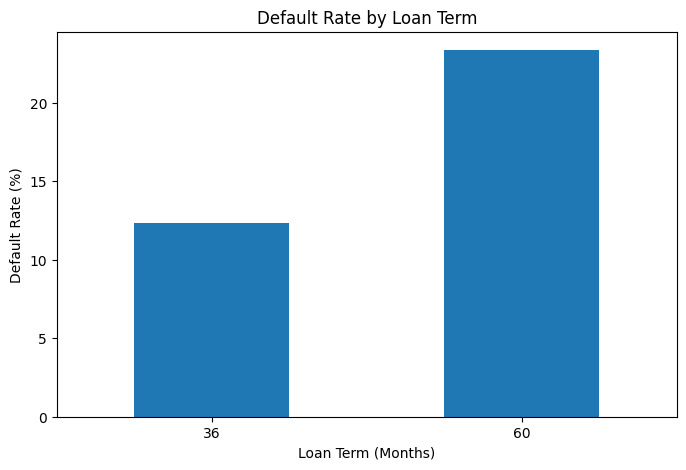

In [219]:
# Calculate the percentage of defaults for each term
default_rates = Loan_Data_explore.groupby('term_numeric')['repay_fail'].mean() * 100

# Plot the default rates
default_rates.plot(kind='bar', figsize=(8, 5))
plt.title("Default Rate by Loan Term")
plt.xlabel("Loan Term (Months)")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=0)
plt.show()

### Overall Analysis for Term Column 

- Longer terms indeed show higher failure rates, the institution might consider tightening the criteria for these loans or adjusting interest rates to mitigate risk.

repay_fail        0     1
term_numeric             
36            25072  3521
60             7579  2308


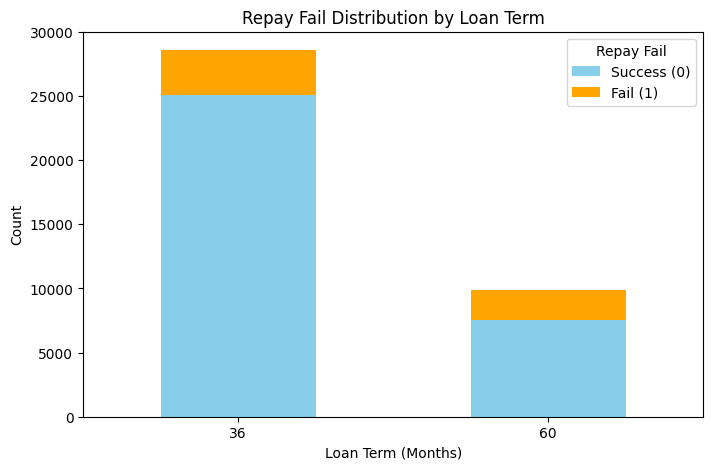

In [71]:
# Calculate counts for repay_fail grouped by term
counts = Loan_Data_explore.groupby(['term_numeric', 'repay_fail']).size().unstack()

print(counts)

# Plot stacked bar chart
counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=['skyblue', 'orange'])
plt.title("Repay Fail Distribution by Loan Term")
plt.xlabel("Loan Term (Months)")
plt.ylabel("Count")
plt.legend(title="Repay Fail", loc="upper right", labels=["Success (0)", "Fail (1)"])
plt.xticks(rotation=0)
plt.show()

In [72]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(Loan_Data_explore['term_numeric'], Loan_Data_explore['repay_fail'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

if p < 0.05:
    print("There is a significant association between term and repay_fail.")
else:
    print("There is no significant association between term and repay_fail.")

Chi-Square Statistic: 694.465629518083
P-Value: 4.777450193462518e-153
There is a significant association between term and repay_fail.


### Analysis of Chi-Square Test for Loan Term Correlation

After looking into the Chi-Square Test, these results indicate that 	

1.	Chi-Square Statistic: 694.47
	
	•	This statistic quantifies the difference between the observed and expected frequencies in the contingency table. A higher value indicates a stronger deviation from what would be expected if there were no association between the variables.
2.	P-Value: 4.78e-153 (very close to 0)
	
	•	The p-value represents the probability of observing the data (or something more extreme) if the null hypothesis (no association between term and repay_fail) were true.
	•	A p-value this small means the likelihood of no association is extremely low.
3.	Conclusion: Significant Association
	
	•	Since the p-value is much smaller than the typical significance threshold (e.g., 0.05), we reject the null hypothesis. This means there is strong evidence of a significant association between term and repay_fail.

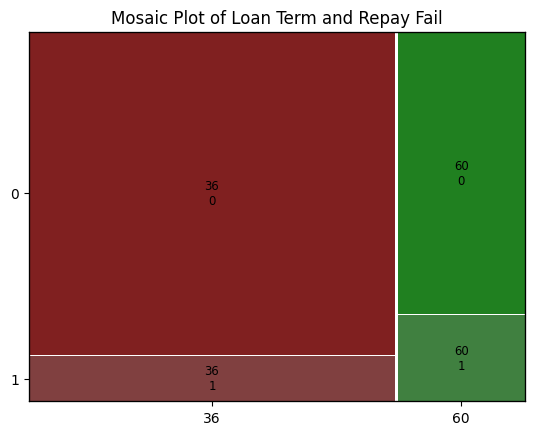

In [74]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic(Loan_Data_explore, ['term_numeric', 'repay_fail'])
plt.title("Mosaic Plot of Loan Term and Repay Fail")
plt.show()

In [46]:
# Group by 'home_ownership' and calculate the mean of 'repay_fail'
home_ownership_repay_fail = Loan_Data.groupby('home_ownership')['repay_fail'].mean()

# Sort the results to see which home ownership categories have the highest failure rates
sorted_home_ownership_repay_fail = home_ownership_repay_fail.sort_values(ascending=False)
print(sorted_home_ownership_repay_fail)


home_ownership
NONE        0.250000
OTHER       0.232000
RENT        0.158330
OWN         0.155849
MORTGAGE    0.142824
Name: repay_fail, dtype: float64


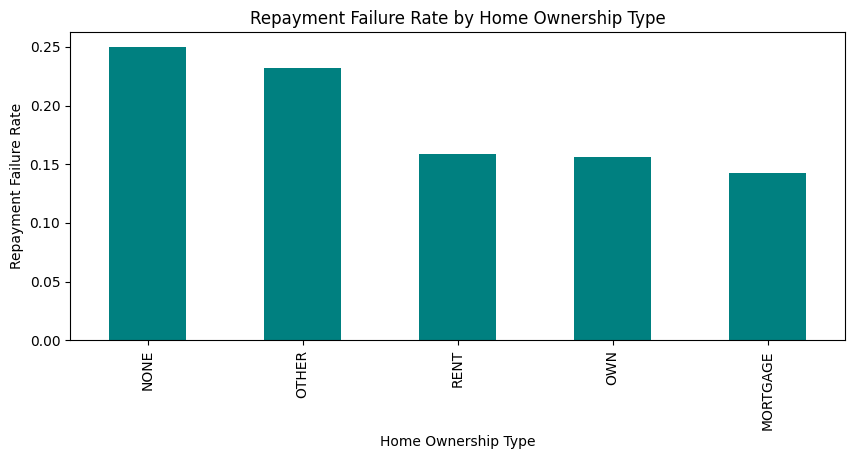

In [48]:
import matplotlib.pyplot as plt

# Create a bar plot for 'repay_fail' rates by 'home_ownership'
sorted_home_ownership_repay_fail.plot(kind='bar', color='teal', figsize=(10, 4))
plt.title('Repayment Failure Rate by Home Ownership Type')
plt.xlabel('Home Ownership Type')
plt.ylabel('Repayment Failure Rate')
plt.show()


## Analysis of Repayment Failure Rates by Home Ownership Type

### NONE and OTHER
- **Higher Risk**: These categories exhibit higher repayment failure rates compared to other home ownership statuses.
- **Implications**: This might indicate higher risk associated with borrowers who fall into these categories.
  - Particularly, "NONE" might refer to borrowers with no stable home ownership status, which could imply financial instability.

### RENT and OWN
- **Moderate Risk**: The repayment failure rates for renters and homeowners (OWN) are moderately high but relatively lower than the NONE and OTHER categories.
- **Risk Assessment**: This suggests a middle ground in terms of risk. Renters and homeowners with their own homes tend to have more stability than those with no home or categorized as OTHER, but still carry a notable risk of repayment failure.

### MORTGAGE
- **Lower Risk**: Borrowers with mortgages show the lowest repayment failure rate among the groups.
- **Financial Stability**: This might indicate greater financial stability or the presence of more stringent lending criteria for those approved for mortgages, reflecting their lower risk of default.

### Summary
This analysis suggests that lenders might consider differentiating interest rates or loan terms based on home ownership status to better manage risk. Those with stable home ownership like MORTGAGE are less likely to fail in repayments, whereas those with NONE or OTHER could benefit from more rigorous screening or enhanced financial education to mitigate risks associated with financia


In [55]:
# Group by 'addr_state' and calculate the mean of 'repay_fail'
state_repay_fail = Loan_Data.groupby('addr_state')['repay_fail'].mean()

# Sort the results to see which states have the highest failure rates
sorted_state_repay_fail = state_repay_fail.sort_values(ascending=False)
sorted_state_repay_fail


addr_state
ZZ    1.000000
NE    0.500000
IN    0.368421
MS    0.250000
NV    0.235052
AK    0.207792
TN    0.200000
FL    0.186943
MO    0.186115
MT    0.181818
OR    0.169451
UT    0.169291
WA    0.167920
GA    0.167761
HI    0.166667
IA    0.166667
NM    0.166667
MD    0.166337
CA    0.166272
SD    0.157895
KY    0.156550
NH    0.152941
NJ    0.152089
AZ    0.150701
MN    0.149079
MI    0.148305
WI    0.147992
NC    0.147256
SC    0.146119
IL    0.140512
OK    0.137324
NY    0.136683
OH    0.134822
MA    0.132296
PA    0.132126
CT    0.131579
TX    0.131029
AR    0.130252
VA    0.129561
KS    0.129151
DE    0.129032
RI    0.129032
LA    0.127711
AL    0.127563
ID    0.125000
WV    0.120482
CO    0.116732
VT    0.115385
DC    0.076531
WY    0.051282
ME    0.000000
AA    0.000000
Name: repay_fail, dtype: float64

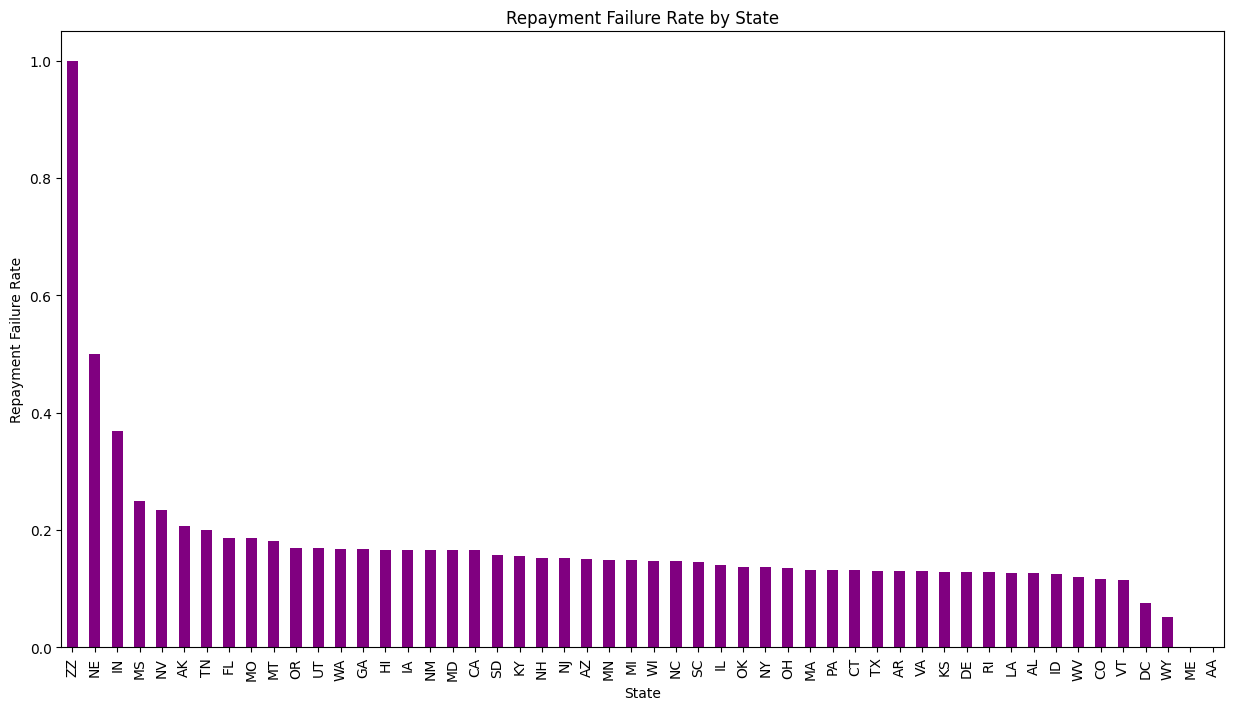

In [56]:
import matplotlib.pyplot as plt

# Create a bar plot for 'repay_fail' rates by 'addr_state'
sorted_state_repay_fail.plot(kind='bar', color='purple', figsize=(15, 8))  # Adjusted for better readability
plt.title('Repayment Failure Rate by State')
plt.xlabel('State')
plt.ylabel('Repayment Failure Rate')
plt.xticks(rotation=90)  # Rotate labels to fit all state abbreviations
plt.show()


 # Analysis of State Addresses
 
 States with Low Data: Several states, marked with "Low data," have very few samples, making their failure rates potentially unreliable or skewed. For instance, states like "AA," "ZZ," or others with very few loans might show extreme repayment failure rates that are not truly indicative of the typical behavior in those states.

In [57]:
import pandas as pd

# Combine the repayment failure rates with the counts
state_analysis = pd.DataFrame({
    'Failure Rate': sorted_state_repay_fail,
    'Sample Size': Loan_Data_explore['addr_state'].value_counts()
})

# Sort by sample size to see which states have the fewest data points
sorted_state_analysis = state_analysis.sort_values(by='Sample Size', ascending=True)
print(sorted_state_analysis)

            Failure Rate  Sample Size
addr_state                           
AA              0.000000            1
ZZ              1.000000            1
ME              0.000000            3
ID              0.125000            8
NE              0.500000           10
IA              0.166667           12
IN              0.368421           19
MS              0.250000           24
TN              0.200000           30
VT              0.115385           52
SD              0.157895           57
AK              0.207792           77
WY              0.051282           78
MT              0.181818           88
DE              0.129032          124
WV              0.120482          166
HI              0.166667          168
NH              0.152941          170
RI              0.129032          186
NM              0.166667          186
DC              0.076531          196
AR              0.130252          238
UT              0.169291          254
KS              0.129151          271
OK          

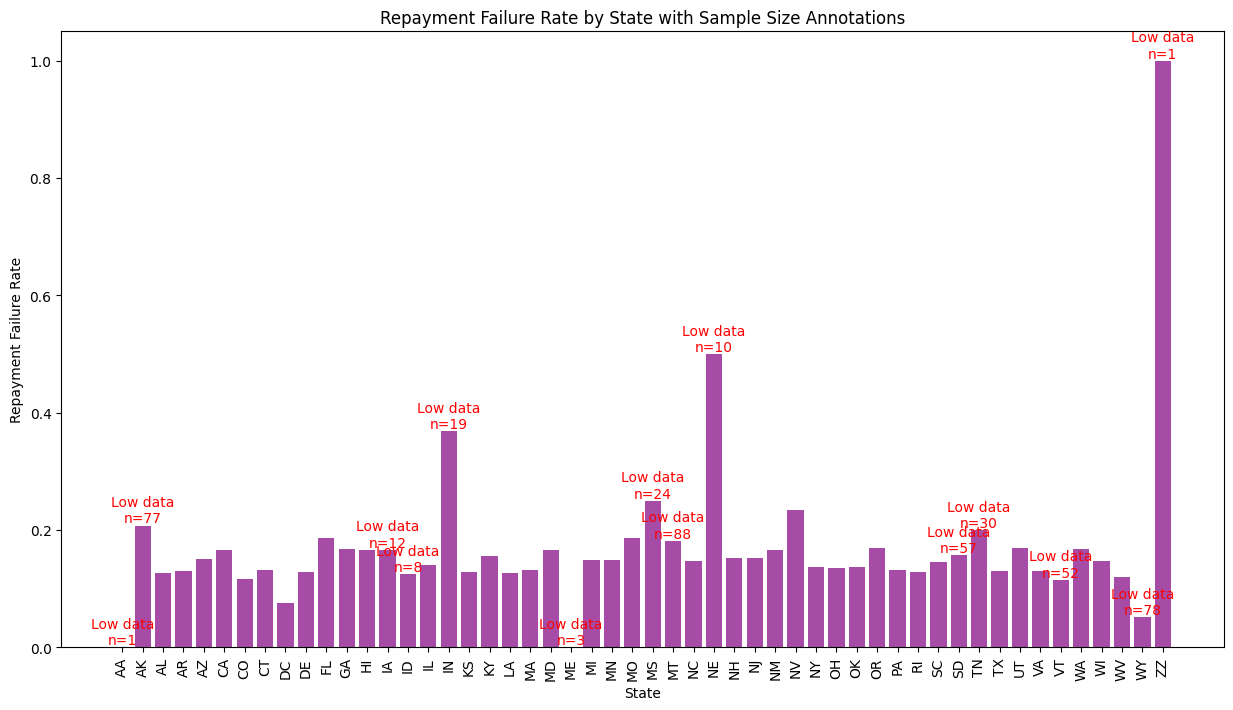

In [58]:
import matplotlib.pyplot as plt

# Plotting with annotations or color coding based on sample size
plt.figure(figsize=(15, 8))
plt.bar(state_analysis.index, state_analysis['Failure Rate'], color='purple', alpha=0.7)
for i, (rate, count) in enumerate(zip(state_analysis['Failure Rate'], state_analysis['Sample Size'])):
    if count < 100:  # Example threshold
        plt.text(i, rate, f'Low data\nn={count}', ha='center', va='bottom', color='red')

plt.title('Repayment Failure Rate by State with Sample Size Annotations')
plt.xlabel('State')
plt.ylabel('Repayment Failure Rate')
plt.xticks(rotation=90)
plt.show()


In [82]:
Loan_Data_explore['last_credit_pull_month'].value_counts()

last_credit_pull_month
6     13011
3      3155
2      2898
4      2602
5      2520
12     2337
11     2098
9      2042
1      1965
10     1959
7      1948
8      1945
Name: count, dtype: int64

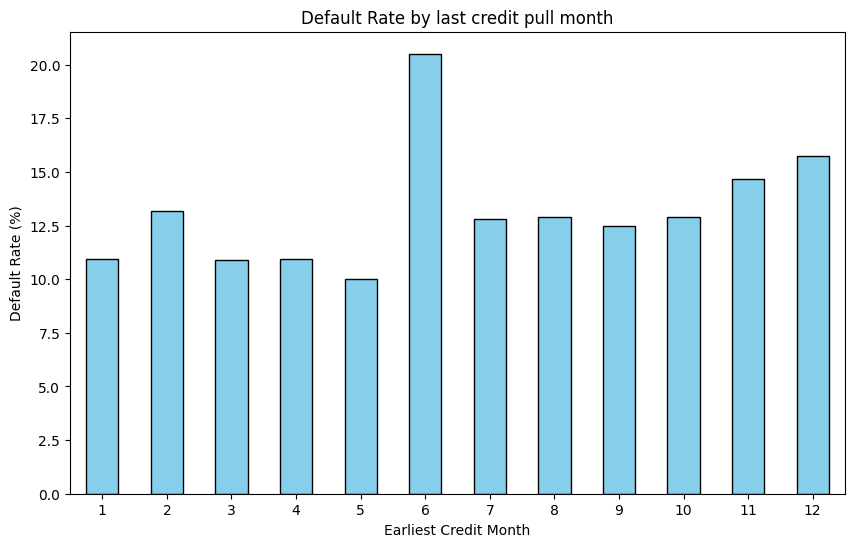

In [81]:
# Calculate the default rate for each month
default_rate_by_month = Loan_Data_explore.groupby('last_credit_pull_month')['repay_fail'].mean() * 100

# Plot the default rates
default_rate_by_month.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title("Default Rate by last credit pull month")
plt.xlabel("Earliest Credit Month")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=0)
plt.show()

In [86]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(Loan_Data_explore['last_credit_pull_month'], Loan_Data_explore['repay_fail'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

if p < 0.05:
    print("There is a significant association between last_credit_pull_month and repay_fail.")
else:
    print("There is no significant association between last_credit_pull_month and repay_fail.")

Chi-Square Statistic: 494.7574996263056
P-Value: 4.207150264367468e-99
There is a significant association between last_credit_pull_month and repay_fail.


In [44]:
Loan_Data_explore['term'].value_counts()

term
36 months    28593
60 months     9887
Name: count, dtype: int64

In [20]:
# Clean the 'term' column to remove ' months' and convert it to an integer
Loan_Data['term'] = Loan_Data['term'].str.replace(' months', '').astype(int)

In [218]:
# Group by 'term' and calculate the mean of 'repay_fail'
term_repay_fail = Loan_Data.groupby('term')['repay_fail'].mean()

term_repay_fail

term
36 months    0.123142
60 months    0.233438
Name: repay_fail, dtype: float64

In [217]:
# Ensure 'repay_fail' is of a numeric type if it isn't already
Loan_Data['repay_fail'] = Loan_Data['repay_fail'].astype(int)

# Group by 'purpose' and calculate the mean of 'repay_fail'
purpose_repay_fail = Loan_Data.groupby('purpose')['repay_fail'].mean()

# Sort the results to see which loan purposes have the highest failure rates
sorted_purpose_repay_fail = purpose_repay_fail.sort_values(ascending=False)
print(sorted_purpose_repay_fail)


purpose
small_business        0.278208
educational           0.212435
renewable_energy      0.175824
medical               0.173333
other                 0.172152
moving                0.165480
house                 0.162791
debt_consolidation    0.155216
vacation              0.147222
home_improvement      0.132368
credit_card           0.115802
car                   0.110061
wedding               0.110011
major_purchase        0.104858
Name: repay_fail, dtype: float64


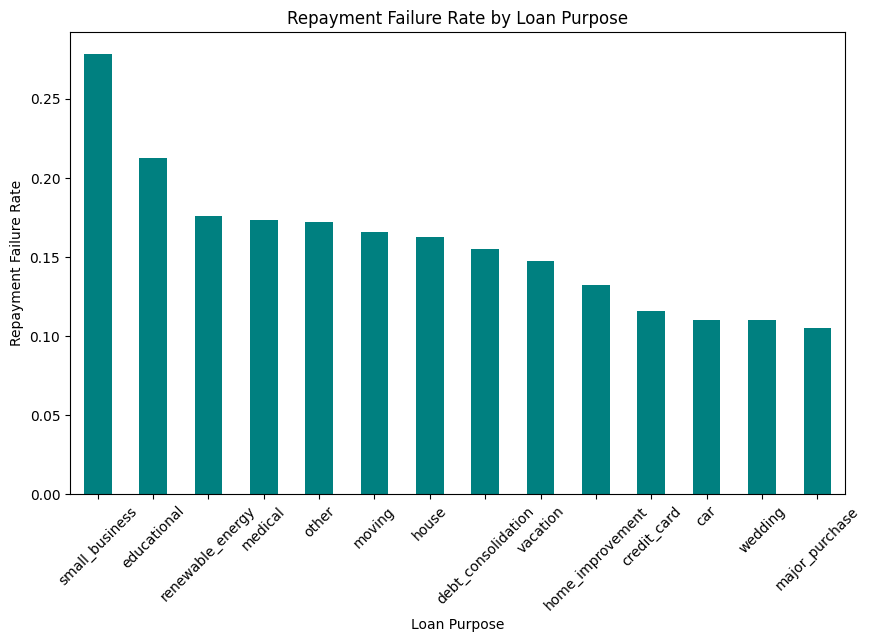

In [74]:
import matplotlib.pyplot as plt

# Create a bar plot for 'repay_fail' rates by 'purpose'
sorted_purpose_repay_fail.plot(kind='bar', color='teal', figsize=(10, 6))
plt.title('Repayment Failure Rate by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Repayment Failure Rate')
plt.xticks(rotation=45)
plt.show()


- High Risk for Small Business Loans: Loans for small businesses exhibit the highest repayment failure rate. This could be due to the variable success rate of small businesses and the challenges they face, especially in their early stages or during economic downturns.

- Educational and Renewable Energy Loans: These categories also show relatively high failure rates. The high rate for educational loans might be linked to the financial burden on individuals who might not yet have stable incomes post-education. Renewable energy loans could be subject to high rates due to the upfront costs versus long-term returns, which might not always align with borrower expectations or financial realities.

- Lower Risk for Secured and Personal Loans: Loans made for cars, weddings, and major purchases, which are often either secured or associated with very personal commitments, show relatively lower default rates. This might indicate that borrowers prioritize these payments or that these loans often involve more stringent credit checks.

- Debt Consolidation and Credit Card Refinancing: These are relatively high in terms of loan purposes but have moderate default rates. This could indicate effectiveness in managing borrower risk or that these borrowers are generally more engaged in managing their finances.

## Prepare the Data 


1. Data cleaning
- Remove or fill missing values.
- Fix or remove outliers.
- Convert types.

 2. Feature selection (optional)
- Drop the attributes that provide no useful information for the task.

3. Feature engineering
- Discretize continuous features.
- Decompose features (e.g., categorical, date/time).
- Add promising transformations of features (e.g., log(x), sqrt(x), x^2, ...).

4. Feature scaling
- Standardize or normalize features.

In [150]:
# Transformer to drop columns

class FinancialRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # No fitting required, return self
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = X.copy()

        # Calculate the ratio of loan amount to annual income
        if 'loan_amnt' in X.columns and 'annual_inc' in X.columns:
            X['loan_amnt_to_annual_inc'] = X['loan_amnt'] / X['annual_inc']
        
        # Calculate the ratio of monthly installment to monthly income
        if 'installment' in X.columns and 'annual_inc' in X.columns:
            X['installment_to_monthly_inc'] = X['installment'] / (X['annual_inc'] / 12)

        return X

class RevolConversionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting required

    def transform(self, X):
        # Ensure X is a DataFrame
        X = X.copy()

        # Remove non-numeric characters and convert 'revol_util' to numeric
        if 'revol_util' in X.columns:
            X['revol_util'] = X['revol_util'].str.replace('[^0-9.]', '', regex=True)
            X['revol_util'] = pd.to_numeric(X['revol_util'], errors='coerce') / 100.0

        return X

# Custom Transformer to log transform annual income and categorize it
class AnnualIncomeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Define the bins and labels for categorization
        self.bins = [0, 30000, 60000, np.inf]
        self.labels = ['low', 'medium', 'high']

    def fit(self, X, y=None):
        # Fit method does nothing but return self (required by scikit-learn)
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = X.copy()
        
        # Create a new column for the log transformation of annual income
        X['log_annual_inc'] = np.log(X['annual_inc'] + 1)
        
        # Categorize based on the log_annual_inc
        X['income_category'] = pd.cut(X['log_annual_inc'], bins=self.bins, labels=self.labels)
        
        # Fill missing income categories with 'low'
        X['income_category'] = X['income_category'].fillna('low')
        
        return X
    


class EarliestCreditLineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Mapping for months
        self.months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                       'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

    def fit(self, X, y=None):
        # Fit method does nothing but return self
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = X.copy()
        
        # Map months to numbers
        X['earliest_cr_month'] = X['earliest_cr_line'].str[:3].map(self.months)

        # Extract the year from 'earliest_cr_line'
        X['earliest_cr_year'] = X['earliest_cr_line'].str[-2:].astype(int)

        # Get the current year and month
        current_year = datetime.now().year % 100  # Get the last two digits of the current year
        current_month = datetime.now().month

        # Determine if year is in 20th or 21st century
        X['earliest_cr_year'] = np.where(
            (X['earliest_cr_year'] <= current_year) & (X['earliest_cr_month'] <= current_month),
            X['earliest_cr_year'] + 2000,
            X['earliest_cr_year'] + 1900
        )

        # Calculate years since the earliest credit line
        X['years_since_earliest_cr_line'] = datetime.now().year - X['earliest_cr_year']

        return X
    


class SpecialMissingValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting required

    def transform(self, X):
        # Ensure X is a DataFrame
        X = X.copy()

        # Special handling for specific columns
        if 'mths_since_last_delinq' in X.columns:
            X['mths_since_last_delinq'] = X['mths_since_last_delinq'].fillna(0)

        return X
    


class LastCreditPullTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Mapping for months
        self.months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                       'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

    def fit(self, X, y=None):
        # Fit method does nothing but return self (no training required)
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = X.copy()
        
        # Get the current date
        current_date = datetime.now()
        current_year = current_date.year % 100  # Last two digits of the current year
        current_month = current_date.month

        # Fill missing values in 'last_credit_pull_d' with the current date
        X['last_credit_pull_d'] = X['last_credit_pull_d'].fillna(current_date.strftime('%b-%y'))

        # Extract the month and year from the 'last_credit_pull_d' column
        X['last_credit_pull_month'] = X['last_credit_pull_d'].str[:3].map(self.months)
        X['last_credit_pull_year'] = X['last_credit_pull_d'].str[-2:].astype(int)

        # Determine if year is in the 20th or 21st century
        X['last_credit_pull_year'] = np.where(
            (X['last_credit_pull_year'] <= current_year) & (X['last_credit_pull_month'] <= current_month),
            X['last_credit_pull_year'] + 2000,
            X['last_credit_pull_year'] + 1900
        )

        # Calculate years since the last credit pull
        X['years_since_last_credit_pull'] = datetime.now().year - X['last_credit_pull_year']

        return X



In [215]:

columnsToDrop = [
    'loan_status','total_pymnt', 'zip_code', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 
    'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'funded_amnt', 'funded_amnt_inv', 'open_acc', 'annual_inc', 'addr_state', 'earliest_cr_line', 'last_credit_pull_d'
]

categorical_features = ['term', 'emp_length', 'home_ownership', 'verification_status','purpose','income_category']

numerical_features = [ 
        'loan_amnt','int_rate','installment',
        'dti','delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
        'pub_rec', 'revol_bal', 'revol_util', 'total_acc','loan_amnt_to_annual_inc',
        'installment_to_monthly_inc','log_annual_inc','years_since_earliest_cr_line',
        'earliest_cr_month', 'earliest_cr_year','years_since_earliest_cr_line', 'last_credit_pull_month', 
        'last_credit_pull_year','years_since_last_credit_pull'
        ]


# Define categorical and numerical pipelines
numerical_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute with mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode as one-hot
])

# Define the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_trans, categorical_features),  # Process categorical features
    ('numerical', numerical_trans, numerical_features),         # Process numerical features
    ('drop', 'drop', columnsToDrop)  # Drop unnecessary columns
], remainder='passthrough',
force_int_remainder_cols=False)  # Keep any remaining columns

# Preliminary pipeline for custom transformations
preliminary_pipeline = Pipeline(steps=[
    ('annual_income', AnnualIncomeTransformer()),  # Log-transform and categorize annual income (creates 'log_annual_inc', 'income_category')
    ('financial_ratios', FinancialRatioTransformer()),  # Add loan-to-income and installment-to-income ratios
    ('revol_conversion', RevolConversionTransformer()),  # Clean revol_util
    ('special_missing_values', SpecialMissingValuesTransformer()),  # Handle specific missing values
    ('earliest_credit_line', EarliestCreditLineTransformer()),  # Extract earliest credit line features
    ('last_credit_pull', LastCreditPullTransformer())  # Extract last credit pull features

])

# Final pipeline chaining the two parts together
pipeline = Pipeline(steps=[
    ('preliminary', preliminary_pipeline),  # Run custom transformations
    ('preprocessor', preprocessor)  # Apply preprocessing to transformed data
])

# Fit and transform the data
transformed_data = pipeline.fit_transform(train_data)



# View pipeline steps
pipeline

Pipeline(steps=[('preliminary',
                 Pipeline(steps=[('annual_income', AnnualIncomeTransformer()),
                                 ('financial_ratios',
                                  FinancialRatioTransformer()),
                                 ('revol_conversion',
                                  RevolConversionTransformer()),
                                 ('special_missing_values',
                                  SpecialMissingValuesTransformer()),
                                 ('earliest_credit_line',
                                  EarliestCreditLineTransformer()),
                                 ('last_credit_pull',
                                  LastCreditPullTransfor...
                                                   'last_credit_pull_month',
                                                   'last_credit_pull_year',
                                                   'years_since_last_credit_pull']),
                                                 ('drop', 'drop',
                                                  ['loan_status', 'total_pymnt',
                                                   'zip_code',
                                                   'total_pymnt_inv',
                                                   'total_rec_prncp',
                                                   'total_rec_int',
                                                   'last_pymnt_amnt', 'issue_d',
                                                   'last_pymnt_d',
                                                   'next_pymnt_d',
                                                   'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'open_acc', 'annual_inc',
                                                   'addr_state',
                                                   'earliest_cr_line',
                                                   'last_credit_pull_d'])]))])

## Short-List Promising Models

1. **Train many quick and dirty models from different categories** (e.g., linear, naive Bayes, SVM, Random Forests, neural net, ...) using standard parameters.

2. **Measure and compare their performance.** For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.

3. **Analyze the most significant variables for each algorithm.**
4. **Analyze the types of errors the models make.** What data would a human have used to avoid these errors?

5. **Have a quick round of feature selection and engineering.**

6. **Have one or two more quick iterations of the five previous steps.**

7. **Short-list the top three to five most promising models,** preferring models that make different types of errors.


### Automate what you can.
- If the data is huge you may want to sample smaller training sets so you can train many different models faster (this may penalize more complex models though).

In [198]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [199]:
label = transformed_data['remainder__repay_fail']

transformed_data = transformed_data.drop(columns=['remainder__repay_fail'])



In [200]:
# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Fit the model
log_reg.fit(transformed_data, label)

# Evaluate on training data
log_preds = log_reg.predict(transformed_data)
log_train_accuracy = accuracy_score(label, log_preds)

# Cross-validation
log_cv_scores = cross_val_score(log_reg, transformed_data, label, cv=10, scoring="accuracy")
log_cv_mean = log_cv_scores.mean()

# Print results
print("Logistic Regression Training Accuracy:", log_train_accuracy)
print("Logistic Regression Cross-Validation Accuracy:", log_cv_mean)
print(classification_report(label, log_preds))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Logistic Regression Training Accuracy: 0.8479080041580042
Logistic Regression Cross-Validation Accuracy: 0.8474531827144034
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     26121
           1       0.47      0.03      0.05      4663

    accuracy                           0.85     30784
   macro avg       0.66      0.51      0.48     30784
weighted avg       0.79      0.85      0.79     30784



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [201]:
# Initialize Decision Tree with depth limit
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit the model
dt_clf.fit(transformed_data, label)

# Evaluate on training data
dt_preds = dt_clf.predict(transformed_data)
dt_train_accuracy = accuracy_score(label, dt_preds)

# Cross-validation
dt_cv_scores = cross_val_score(dt_clf, transformed_data, label, cv=10, scoring="accuracy")
dt_cv_mean = dt_cv_scores.mean()

# Print results
print("Decision Tree Training Accuracy:", dt_train_accuracy)
print("Decision Tree Cross-Validation Accuracy:", dt_cv_mean)
print(classification_report(label, dt_preds))

Decision Tree Training Accuracy: 0.8517086798336798
Decision Tree Cross-Validation Accuracy: 0.8486552092282478
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     26121
           1       0.62      0.05      0.10      4663

    accuracy                           0.85     30784
   macro avg       0.74      0.52      0.51     30784
weighted avg       0.82      0.85      0.80     30784



In [202]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_clf.fit(transformed_data, label)

# Evaluate on training data
rf_preds = rf_clf.predict(transformed_data)
rf_train_accuracy = accuracy_score(label, rf_preds)

# Cross-validation
rf_cv_scores = cross_val_score(rf_clf, transformed_data, label, cv=10, scoring="accuracy")
rf_cv_mean = rf_cv_scores.mean()

# Print results
print("Random Forest Training Accuracy:", rf_train_accuracy)
print("Random Forest Cross-Validation Accuracy:", rf_cv_mean)
print(classification_report(label, rf_preds))

Random Forest Training Accuracy: 1.0
Random Forest Cross-Validation Accuracy: 0.8537877478510971
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26121
           1       1.00      1.00      1.00      4663

    accuracy                           1.00     30784
   macro avg       1.00      1.00      1.00     30784
weighted avg       1.00      1.00      1.00     30784



In [203]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gb_clf.fit(transformed_data, label)

# Evaluate on training data
gb_preds = gb_clf.predict(transformed_data)
gb_train_accuracy = accuracy_score(label, gb_preds)

# Cross-validation
gb_cv_scores = cross_val_score(gb_clf, transformed_data, label, cv=10, scoring="accuracy")
gb_cv_mean = gb_cv_scores.mean()

# Print results
print("Gradient Boosting Training Accuracy:", gb_train_accuracy)
print("Gradient Boosting Cross-Validation Accuracy:", gb_cv_mean)
print(classification_report(label, gb_preds))

Gradient Boosting Training Accuracy: 0.8597648128898129
Gradient Boosting Cross-Validation Accuracy: 0.8548272784616323
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     26121
           1       0.70      0.13      0.22      4663

    accuracy                           0.86     30784
   macro avg       0.78      0.56      0.57     30784
weighted avg       0.84      0.86      0.82     30784



In [204]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize Balanced Random Forest
brf_clf = BalancedRandomForestClassifier(
    n_estimators=200,        # Number of trees in the forest
    random_state=42,         # Ensures reproducibility
    max_depth=10             # Maximum depth of each tree (tune based on your data)
)

# Fit the model to the training data
brf_clf.fit(transformed_data, label)

# Make predictions on the training data
brf_preds = brf_clf.predict(transformed_data)

# Evaluate the model
print("Balanced Random Forest Training Accuracy:", accuracy_score(label, brf_preds))
print("\nClassification Report:\n", classification_report(label, brf_preds))

# Perform cross-validation
cv_scores_brf = cross_val_score(brf_clf, transformed_data, label, cv=5, scoring="accuracy")
print("\nCross-Validation Accuracy (mean):", cv_scores_brf.mean())
print("Cross-Validation Scores:", cv_scores_brf)

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(label, brf_preds))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in th

Balanced Random Forest Training Accuracy: 0.7459069646569647

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.72      0.83     26121
           1       0.36      0.87      0.51      4663

    accuracy                           0.75     30784
   macro avg       0.66      0.80      0.67     30784
weighted avg       0.88      0.75      0.78     30784



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in th


Cross-Validation Accuracy (mean): 0.6994542469661361
Cross-Validation Scores: [0.69839207 0.711223   0.6918954  0.69676791 0.69899285]

Confusion Matrix:
 [[18905  7216]
 [  606  4057]]


In [205]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize Ridge Classifier
ridge_clf = RidgeClassifier(alpha=1.0, random_state=42)  # Adjust alpha for regularization strength

# Fit the model to the training data
ridge_clf.fit(transformed_data, label)

# Make predictions on the training data
ridge_preds = ridge_clf.predict(transformed_data)

# Evaluate the model
print("Ridge Classifier Training Accuracy:", accuracy_score(label, ridge_preds))
print("\nClassification Report:\n", classification_report(label, ridge_preds))

# Perform cross-validation
cv_scores_ridge = cross_val_score(ridge_clf, transformed_data, label, cv=5, scoring="accuracy")
print("\nCross-Validation Accuracy (mean):", cv_scores_ridge.mean())
print("Cross-Validation Scores:", cv_scores_ridge)

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(label, ridge_preds))

Ridge Classifier Training Accuracy: 0.8489150207900208

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     26121
           1       0.64      0.01      0.01      4663

    accuracy                           0.85     30784
   macro avg       0.74      0.50      0.47     30784
weighted avg       0.82      0.85      0.78     30784


Cross-Validation Accuracy (mean): 0.8487850825217507
Cross-Validation Scores: [0.84862758 0.84911483 0.84846516 0.84895241 0.84876543]

Confusion Matrix:
 [[26105    16]
 [ 4635    28]]


In [206]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Define the SVC model
svc_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Fit the model to the training data
svc_clf.fit(transformed_data, label)

# Make predictions on the training data (since it's already split)
y_pred = svc_clf.predict(transformed_data)

# Evaluate the model's performance
print("SVC Training Accuracy:", accuracy_score(label, y_pred))
print("\nClassification Report:\n", classification_report(label, y_pred))

# Perform cross-validation to assess generalization
cv_scores = cross_val_score(svc_clf, transformed_data, label, cv=5, scoring="accuracy")
print("\nCross-Validation Accuracy (mean):", cv_scores.mean())
print("Cross-Validation Scores:", cv_scores)

SVC Training Accuracy: 0.8485252079002079

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     26121
           1       0.00      0.00      0.00      4663

    accuracy                           0.85     30784
   macro avg       0.42      0.50      0.46     30784
weighted avg       0.72      0.85      0.78     30784



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Cross-Validation Accuracy (mean): 0.8485252104267973
Cross-Validation Scores: [0.84862758 0.84846516 0.84846516 0.84846516 0.84860299]


## Fine-Tune the System

1. **Fine-tune the hyperparameters using cross-validation.** Treat your data transformation choices as hyperparameters, especially when you are not sure about them. Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach.

2. **Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.**


In [207]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter search space
param_distributions = {
    'n_estimators': [100, 200, 300, 500],         # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Shrinkage step size
    'max_depth': [3, 5, 7, 10],                  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10, 20],         # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],           # Minimum samples required to be a leaf node
    'subsample': [0.8, 1.0],                     # Fraction of samples used for training each tree
    'max_features': ['sqrt', 'log2', None]       # Number of features to consider for the best split
}

# Set up the Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=gb_clf,
    param_distributions=param_distributions,
    n_iter=50,                   # Number of parameter settings sampled
    scoring='accuracy',          # Evaluation metric
    cv=5,                        # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                    # Use all available cores
)

# Run the Randomized Search
random_search.fit(transformed_data, label)

# Best hyperparameters and score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300, subsample=0.8; total time=  11.6s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300, subsample=0.8; total time=  11.7s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300, subsample=0.8; total time=  11.8s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300, subsample=0.8; total time=  11.8s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300, subsample=0.8; total time=  12.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   4.2s
[CV] END 

In [210]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

optimized_gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0,
    max_features='log2',
    random_state=42
)

# Train the model on the train set
optimized_gb_clf.fit(transformed_data, label)

# Predict on the train set
y_pred = optimized_gb_clf.predict(transformed_data)

# Evaluate precision on the train set
precision = precision_score(label, y_pred)
print("Precision on Training Data:", precision)

# Full classification report
print("Classification Report on Training Data:\n", classification_report(label, y_pred))

# Perform cross-validation to check for overfitting
cv_precision_scores = cross_val_score(
    optimized_gb_clf, transformed_data, label, cv=5, scoring='precision'
)
print("Cross-Validation Precision Scores:", cv_precision_scores)
print("Mean Precision (Cross-Validation):", cv_precision_scores.mean())

Precision on Training Data: 0.9406190777005685
Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     26121
           1       0.94      0.32      0.48      4663

    accuracy                           0.89     30784
   macro avg       0.92      0.66      0.71     30784
weighted avg       0.90      0.89      0.87     30784

Cross-Validation Precision Scores: [0.65277778 0.63687151 0.63133641 0.63809524 0.58796296]
Mean Precision (Cross-Validation): 0.6294087785491642


In [211]:
import pickle
# Save the model to a file
with open('final_gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(optimized_gb_clf, f)
print("Model saved to 'final_gradient_boosting_model.pkl'.")

Model saved to 'final_gradient_boosting_model.pkl'.


In [212]:
import pickle

# Save the preprocessor to a file
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("Preprocessor saved to 'preprocessor.pkl'.")

Preprocessor saved to 'preprocessor.pkl'.


In [216]:
from sklearn.ensemble import GradientBoostingClassifier

# Ensure the target column 'repay_fail' is excluded during transformation
datatrain_features = train_data.drop(columns=['repay_fail'])
datatrain_labels = train_data['repay_fail']

# Fit the pipeline on the training data
transformed_train_data = pipeline.fit_transform(datatrain_features)

# Train the final model
final_gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0,
    max_features='log2',
    random_state=42
)
final_gb_clf.fit(transformed_train_data, datatrain_labels)

# Prepare the test data
test_features = test_data.drop(columns=['repay_fail'])  # Exclude the target column
test_labels = test_data['repay_fail']  # Extract the target column

# Transform the test features
test_features_transformed = pipeline.transform(test_features)

# Predict on the test set
y_test_pred = final_gb_clf.predict(test_features_transformed)

# Evaluate performance on the test set
accuracy = accuracy_score(test_labels, y_test_pred)
precision = precision_score(test_labels, y_test_pred)

print("Final Model Accuracy on Test Set:", accuracy)
print("Final Model Precision on Test Set:", precision)
print("Classification Report on Test Set:\n", classification_report(test_labels, y_test_pred))

Final Model Accuracy on Test Set: 0.8581081081081081
Final Model Precision on Test Set: 0.6340579710144928
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      6530
           1       0.63      0.15      0.24      1166

    accuracy                           0.86      7696
   macro avg       0.75      0.57      0.58      7696
weighted avg       0.83      0.86      0.82      7696

